In [105]:
import json
import os
import sys

from datetime import datetime
from functools import partial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile

from matplotlib.dates import DateFormatter


pd.set_option("display.max_columns", None)
sys.path.append("../..")

from src.utils.download import download_file_from_url
from src.utils.plot import plot_bar, plot_hist, plot_pie, heatmap_from_df_cols
from src.utils.states import abbrev_to_state

INPUT_DATA_DIR = "./input_data"
OUTPUT_IMAGE_DIR = "./images/wa_external_appeals"
OUTPUT_DATA_DIR = "./output_data/wa_external_appeals"  # Set to None if you don't want to save non-required data for external use

In [106]:
os.makedirs(INPUT_DATA_DIR, exist_ok=True)
if OUTPUT_IMAGE_DIR:
    os.makedirs(OUTPUT_IMAGE_DIR, exist_ok=True)
if OUTPUT_DATA_DIR:
    os.makedirs(OUTPUT_DATA_DIR, exist_ok=True)

In [107]:
# Manually grabbed yearly data from https://fortress.wa.gov/oic/consumertoolkit/Search.aspx?searchtype=indrev
# And renamed exports as below. This is annoyingly a manual step required to run this notebook for now.
# TODO: automate the data scraping via selenium, or some such. For now, to reproduce, go to site above, filter by one year
# at a time, "search", export results to csv with naming pattern below. Place all files in INPUT_DATA_DIR specified above.
dfs = []
for year in range(2016, 2023 + 1):
    year_df_path = os.path.join(INPUT_DATA_DIR, f"WAStateReviewDecision_{year}.csv")
    year_df = pd.read_csv(year_df_path)
    dfs.append(year_df)
df = pd.concat(dfs, ignore_index=True)
df.to_csv(os.path.join(OUTPUT_DATA_DIR, "wa_external_appeals.csv"), index=False)

In [108]:
YEAR_COL = "Year of Decision"
REVIEW_ORG_COL = "IRO Name"

# Remove two 1900 records, as it appears to be a typo on date.
# Unclear what actual date is, so throw out record
df = df[df[YEAR_COL] != 1900]

In [109]:
print(f"This dataset contains a total of {len(df)} external appeals from WA.")
for year, count in df[YEAR_COL].value_counts(sort=False).items():
    print(f"\t{count} external appeals from {year}")

df = df[df[YEAR_COL] != 2023]

This dataset contains a total of 8774 external appeals from WA.
	955 external appeals from 2016
	1745 external appeals from 2018
	1318 external appeals from 2017
	1287 external appeals from 2019
	908 external appeals from 2020
	959 external appeals from 2021
	1102 external appeals from 2022
	500 external appeals from 2023


In [110]:
df["Outcome"].unique()

array(['Upheld', 'Withdrawn by the Carrier', 'Overturned',
       'IRO Unavailable', 'Withdrawn by the Enrollee'], dtype=object)

In [111]:
def get_overturn_rates_by_category(
    df: pd.DataFrame,
    cat_col: str,
    by_year: bool = False,
    outcome_col: str = "Outcome",
    upheld_cat_name: str = "Upheld",
    overturned_cat_name: str = "Overturned",
    year_cat_name: str = YEAR_COL,
) -> dict:
    """Given a column in df, specified by cat_col, break down appeal decision outcomes split on distinct values in the column."""
    decision_data = {}
    for val in df[cat_col].unique():
        decision_data[val] = {}
        rel_df = df[df[cat_col] == val]
        overturn_counts = rel_df[outcome_col].value_counts()
        decision_data[val]["overall"] = {}
        overturned = overturn_counts.get(overturned_cat_name, 0)
        decision_data[val]["overall"]["overturned"] = overturned
        upheld = overturn_counts.get(upheld_cat_name, 0)
        decision_data[val]["overall"]["upheld"] = upheld
        withdrew = overturn_counts.get(
            "Withdrawn by the Carrier", 0
        ) + overturn_counts.get("Withdrawn by the Enrollee", 0)
        iro_unavailable = overturn_counts.get("IRO Unavailable", 0)
        decision_data[val]["overall"]["iro_unavailable"] = iro_unavailable
        decision_data[val]["overall"]["withdrew"] = withdrew
        decision_data[val]["overall"]["overturn_rate"] = (
            overturned / overturn_counts.values.sum() if overturned else None
        )
        decision_data[val]["overall"]["external_appeals_submitted"] = (
            overturn_counts.values.sum() if overturned else None
        )

        if by_year:
            for year in rel_df[year_cat_name].unique():
                decision_data[val][year] = {}
                sub_df = rel_df[rel_df[year_cat_name] == year]
                overturn_counts = sub_df[outcome_col].value_counts()
                overturned = overturn_counts.get(overturned_cat_name, 0)
                upheld = overturn_counts.get(upheld_cat_name, 0)
                decision_data[val][year]["upheld"] = upheld
                decision_data[val][year]["overturned"] = overturned
                withdrew = overturn_counts.get(
                    "Withdrawn by the Carrier", 0
                ) + overturn_counts.get("Withdrawn by the Enrollee", 0)
                iro_unavailable = overturn_counts.get("IRO Unavailable", 0)
                decision_data[val][year]["iro_unavailable"] = iro_unavailable
                decision_data[val][year]["withdrew"] = withdrew
                decision_data[val][year]["overturn_rate"] = (
                    overturned / overturn_counts.values.sum() if overturned else None
                )
                decision_data[val][year]["external_appeals_submitted"] = (
                    overturn_counts.values.sum() if overturned else None
                )

    return decision_data


def print_appeal_results(appeal_decision_counts):
    bar_names, bar_vals = (
        list(appeal_decision_counts.index),
        appeal_decision_counts.values,
    )
    print(bar_names)
    print(
        f"{int(100* (round(bar_vals[0]/ bar_vals.sum(), 2)))}% of all original determinations in external appeals were upheld"
    )
    print(
        f"{int(100* (round(bar_vals[1]/ bar_vals.sum(), 2)))}% of all original determinations in external appeals were overturned."
    )
    return None

In [112]:
appeal_decision_counts = df["Outcome"].value_counts()
print_appeal_results(appeal_decision_counts)

['Upheld', 'Overturned', 'Withdrawn by the Carrier', 'IRO Unavailable', 'Withdrawn by the Enrollee']
68% of all original determinations in external appeals were upheld
25% of all original determinations in external appeals were overturned.


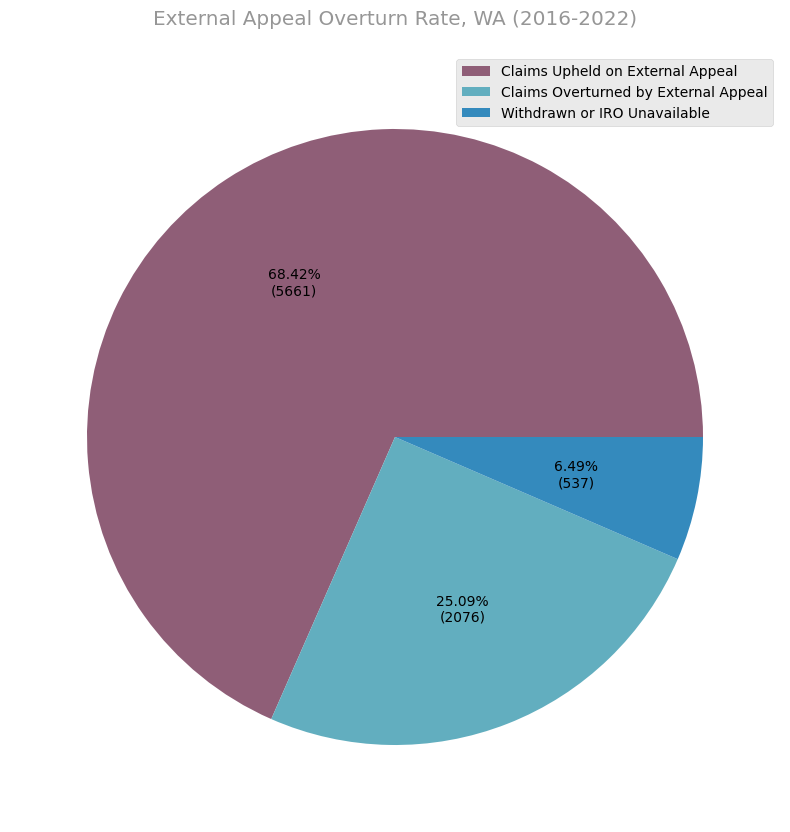

In [113]:
claims_externally_appealed = (
    appeal_decision_counts["Upheld"]
    + appeal_decision_counts["Overturned"]
    + appeal_decision_counts["Withdrawn by the Carrier"]
    + appeal_decision_counts["IRO Unavailable"]
    + appeal_decision_counts["Withdrawn by the Enrollee"]
)
claims_externally_overturned = appeal_decision_counts["Overturned"]
claims_externally_upheld = appeal_decision_counts["Upheld"]
other = (
    claims_externally_appealed - claims_externally_overturned - claims_externally_upheld
)
plot_pie(
    slice_names=[
        "Claims Upheld on External Appeal",
        "Claims Overturned by External Appeal",
        "Withdrawn or IRO Unavailable",
    ],
    slice_vals=[claims_externally_upheld, claims_externally_overturned, other],
    title="External Appeal Overturn Rate, WA (2016-2022)",
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeal_success_rates.png"),
    show=True,
)

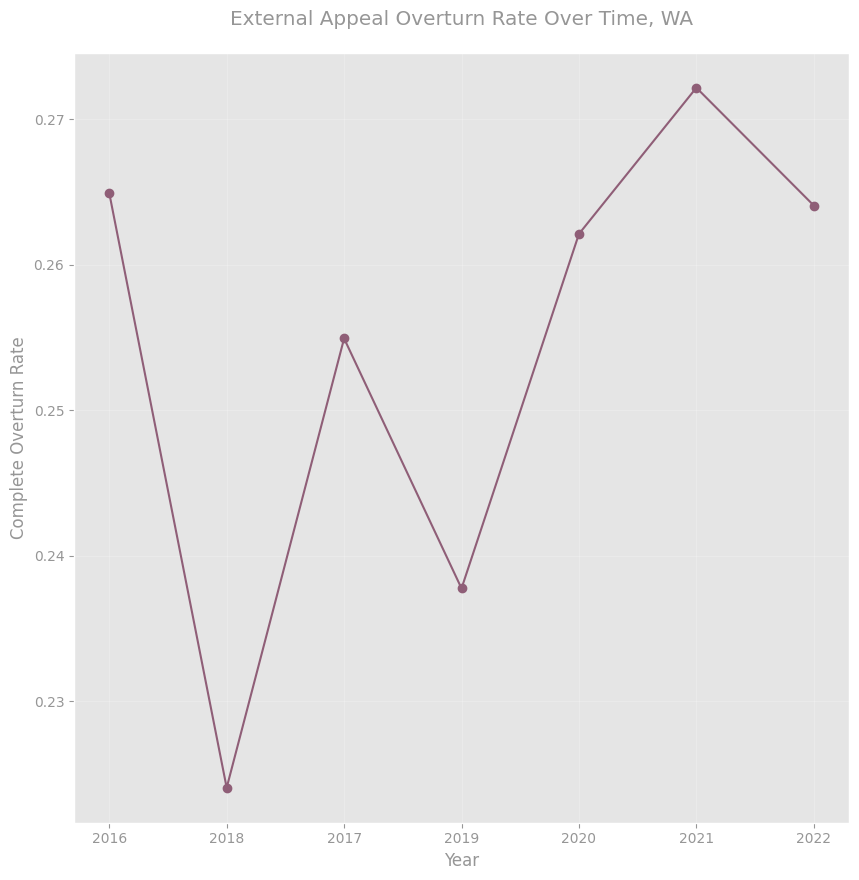

In [114]:
# Plot overall decision rates by year
decision_data = get_overturn_rates_by_category(df, YEAR_COL)
fig, ax = plt.subplots(figsize=(10, 10))
x = list(df[YEAR_COL].unique())
ax.set_title("External Appeal Overturn Rate Over Time, WA")
ax.set_ylabel("Complete Overturn Rate")
ax.set_xlabel("Year")
timeseries = []
for year in x:
    if decision_data.get(year, None):
        timeseries.append(decision_data[year]["overall"]["overturn_rate"])
    else:
        timeseries.append(None)
dates = np.asarray(x).astype(str)
ax.plot(dates, timeseries, "o-")
save_path = os.path.join(OUTPUT_IMAGE_DIR, "external_appeal_overturn_rates_by_year.png")
plt.savefig(save_path, transparent=True, bbox_inches="tight")
plt.show()

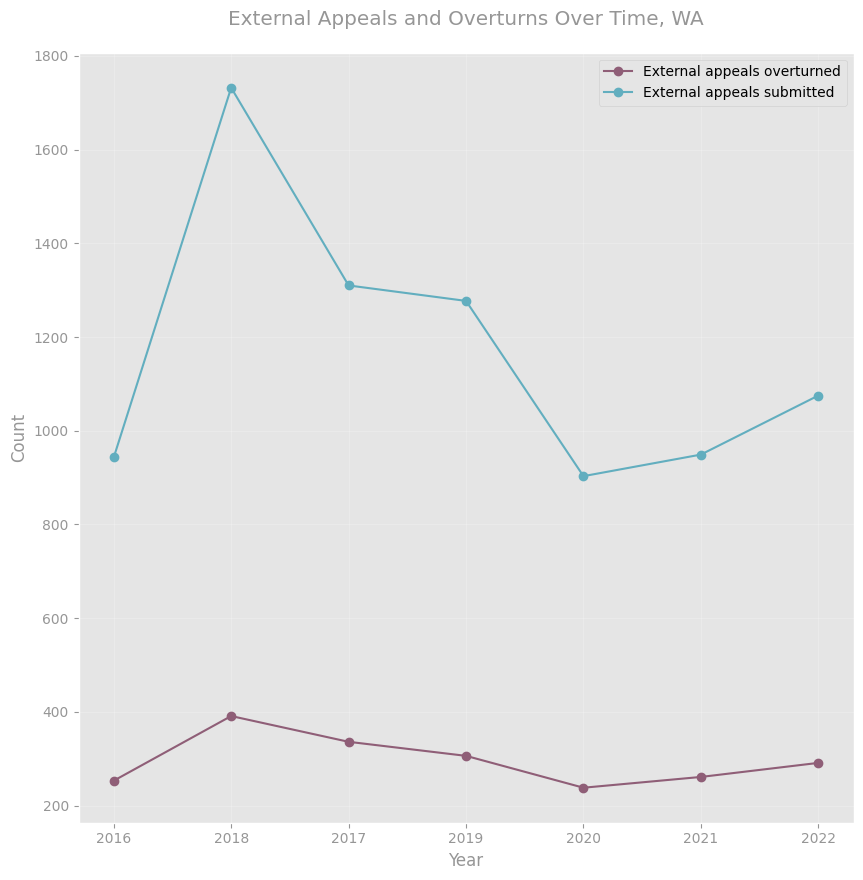

In [115]:
# Plot complete overturns and number of external appeals over same time period, to see what's affecting rate
fig, ax = plt.subplots(figsize=(10, 10))
x = list(df[YEAR_COL].unique())
ax.set_title("External Appeals and Overturns Over Time, WA")
ax.set_ylabel("Count")
ax.set_xlabel("Year")
appeals_timeseries = []
overturns_timeseries = []
for year in x:
    if decision_data.get(year, None):
        year_data = decision_data[year]["overall"]
        appeals_timeseries.append(
            year_data["overturned"] + year_data["withdrew"] + year_data["upheld"]
        )
        overturns_timeseries.append(year_data["overturned"])
    else:
        appeals_timeseries.append(None)
        overturns_timeseries.append(None)
dates = np.asarray(x).astype(str)
ax.plot(dates, overturns_timeseries, "o-", label="External appeals overturned")
ax.plot(dates, appeals_timeseries, "o-", label="External appeals submitted")
ax.legend(labelcolor="black")
save_path = os.path.join(OUTPUT_IMAGE_DIR, "external_appeals_by_year.png")
plt.savefig(save_path, transparent=True, bbox_inches="tight")
plt.show()

In [116]:
# Breakdown Appeals by Initial Denial Rationale
title = "External Appeals by Denial Rationale,\n WA (2016-2022)"
val_axis_label = "Number of External Appeals"
cat_axis_label = "Denial Rationale"
denial_val_counts = df["Reason for request"].value_counts()
bar_names, bar_vals = list(denial_val_counts.index), denial_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    bar_label=True,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeals_by_denial_reason.png"),
    bar_label=True,
    figsize=(10, 8),
)

SyntaxError: keyword argument repeated: bar_label (2133960074.py, line 15)

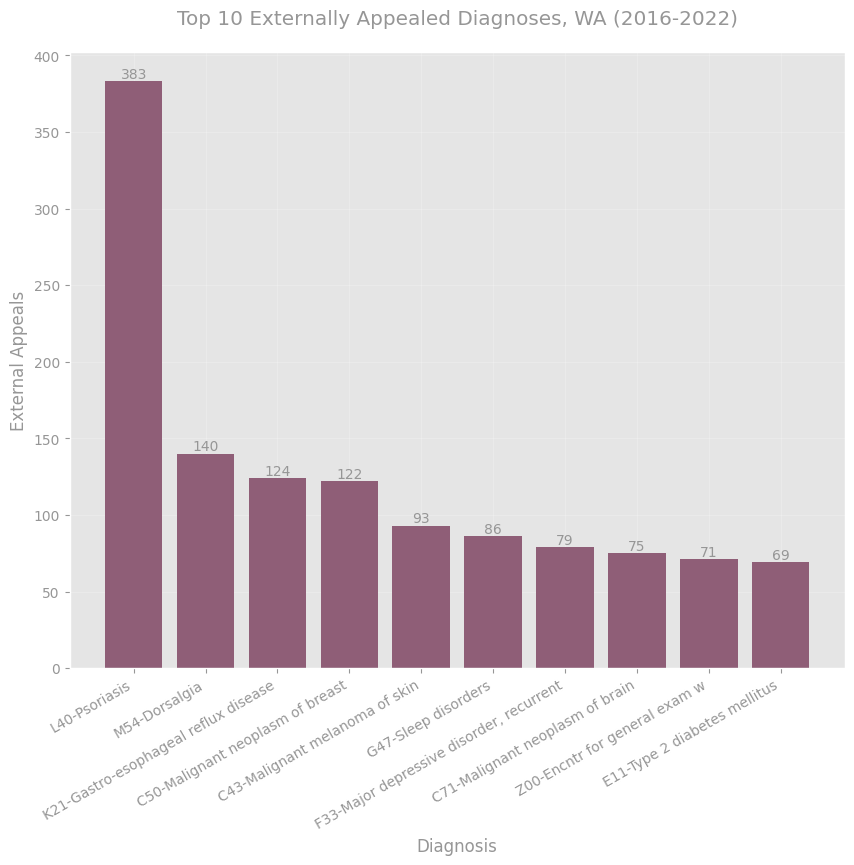

In [ ]:
# Diagnosis breakdowns (via ICD 10 Clinical Modification identifiers)
n = 10
title = f"Top {n} Externally Appealed Diagnoses,\n WA (2016-2022)"
val_axis_label = "External Appeals"
cat_axis_label = "Diagnosis"
diagnosis_val_counts = df["Diagnosis"].value_counts()[:n]
bar_names, bar_vals = list(diagnosis_val_counts.index), diagnosis_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "top_externally_appealed_diagnoses.png"),
    bar_label=True,
    figsize=(10, 8),
)

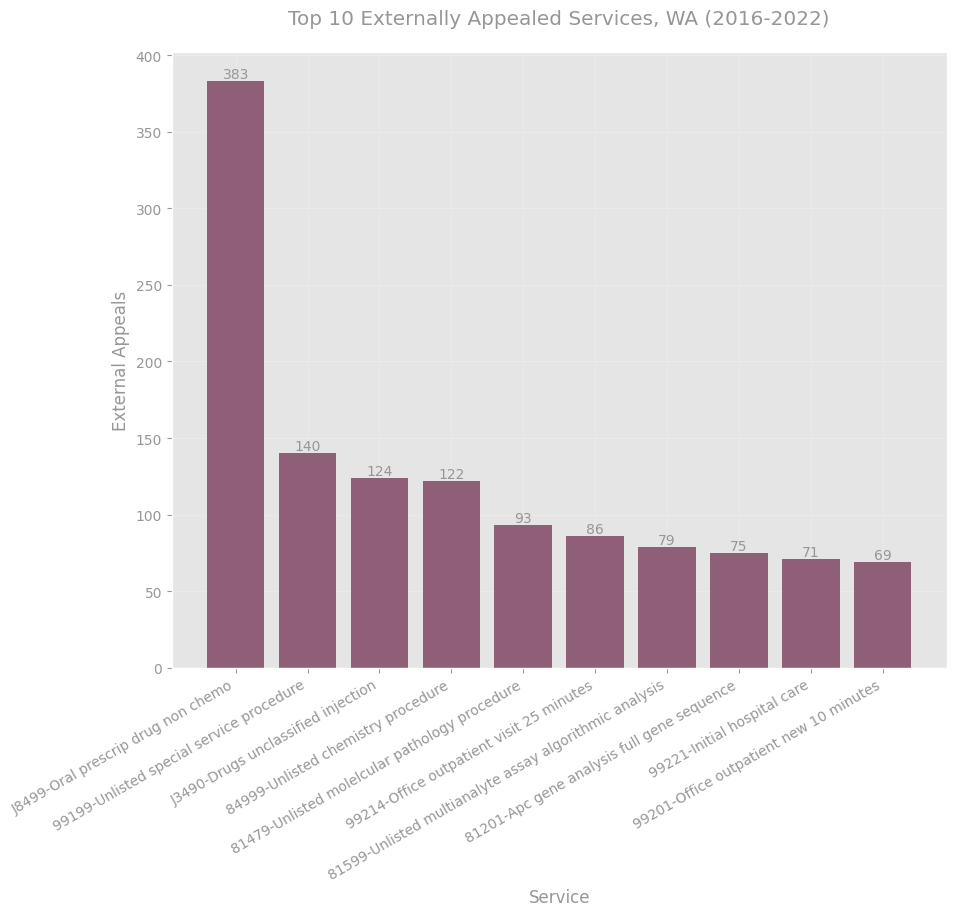

In [ ]:
# Treatment breakdowns (via HCPCS identifiers)
n = 10
title = f"Top {n} Externally Appealed Services,\n WA (2016-2022)"
val_axis_label = "External Appeals"
cat_axis_label = "Service"
treatment_val_counts = df["Treatment"].value_counts()[:n]
bar_names, bar_vals = list(treatment_val_counts.index), diagnosis_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "top_externally_appealed_treatments.png"),
    bar_label=True,
    figsize=(10, 8),
)

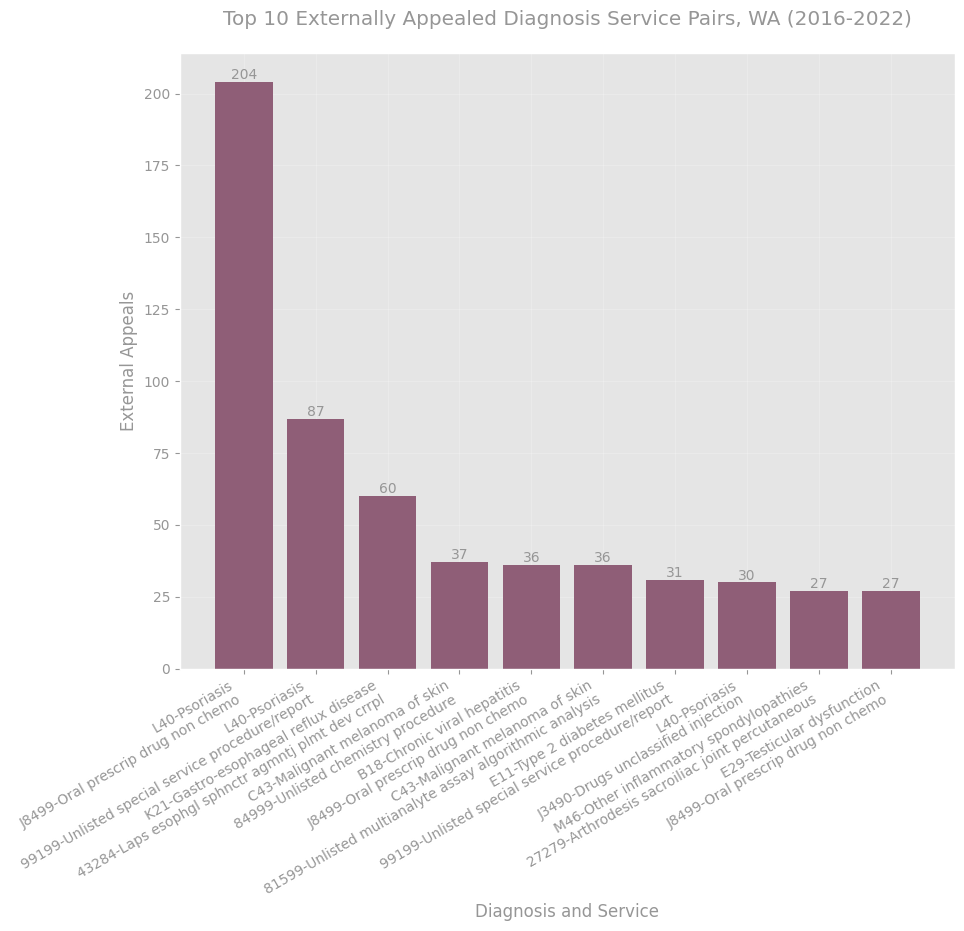

In [ ]:
# Diagnosis/Treatment Pairs
n = 10
title = f"Top {n} Externally Appealed Diagnosis/Service Pairs,\n WA (2016-2022)"
val_axis_label = "External Appeals"
cat_axis_label = "Diagnosis and Service"
diag_treat_pairs = (
    df.groupby(["Diagnosis", "Treatment"], as_index=False)
    .size()
    .sort_values(by="size", ascending=False)[:n]
)
bar_names, bar_vals = [
    x[0] + "\n" + x[1]
    for x in zip(
        diag_treat_pairs["Diagnosis"].values, diag_treat_pairs["Treatment"].values
    )
], diag_treat_pairs["size"].values
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(
        OUTPUT_IMAGE_DIR, "top_externally_appealed_diag_treatments.png"
    ),
    bar_label=True,
    figsize=(10, 8),
)

In [ ]:
decision_data = get_overturn_rates_by_category(df, "CompanyName")

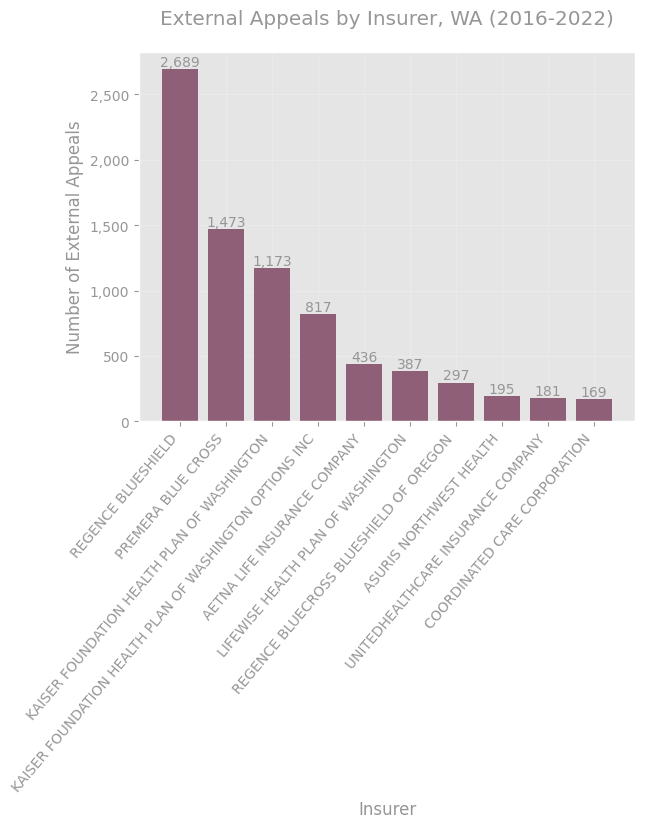

In [ ]:
# Breakdown Appeals Submitted by Insurer (for those with > MIN_APPEALS cases)
MIN_APPEALS = 150
bar_names = []
bar_vals = []
for k, v in decision_data.items():
    v = v["overall"]
    num_external_appeals = v["external_appeals_submitted"]
    if num_external_appeals is not None and num_external_appeals > MIN_APPEALS:
        bar_vals.append(v["external_appeals_submitted"])
        bar_names.append(k)
bar_names, bar_vals = zip(
    *sorted(zip(bar_names, bar_vals), reverse=True, key=lambda x: x[1])
)

# Breakdown Appeals Submitted by Insurer (for those with > MIN_APPEALS cases)
title = "External Appeals by Insurer, WA (2016-2022)"
val_axis_label = "Number of External Appeals"
cat_axis_label = "Insurer"
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeals_by_insurer.png"),
    bar_label=True,
    int_vals=True,
    htick_rotation=50,
    figsize=(10, 8),
)

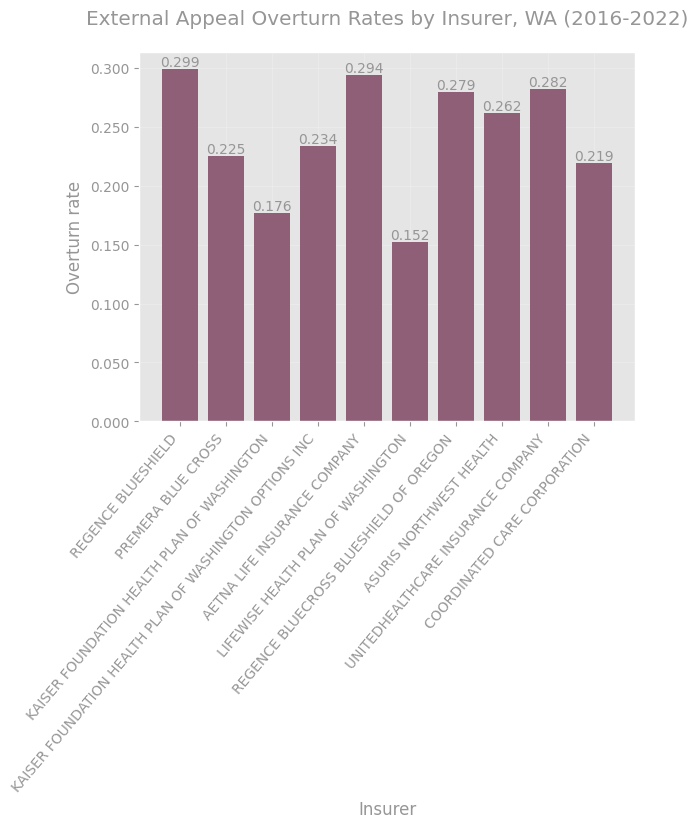

In [ ]:
# Breakdown Appeal Overturn Rates by Insurer (for those with > MIN_APPEALS cases)
MIN_APPEALS = 150
bar_names = []
bar_vals = []
for k, v in decision_data.items():
    v = v["overall"]
    num_external_appeals = v["external_appeals_submitted"]
    if num_external_appeals is not None and num_external_appeals > MIN_APPEALS:
        bar_vals.append([v["overturn_rate"], v["external_appeals_submitted"]])
        bar_names.append(k)
bar_names, bar_vals = zip(
    *sorted(zip(bar_names, bar_vals), reverse=True, key=lambda x: x[1][1])
)

title = "External Appeal Overturn Rates by Insurer,\n WA (2016-2022)"
val_axis_label = "Overturn rate"
cat_axis_label = "Insurer"
plot_bar(
    bar_names,
    [v[0] for v in bar_vals],
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "overturn_rates_by_insurer.png"),
    bar_label=True,
    int_vals=False,
    htick_rotation=50,
    figsize=(10, 8),
)

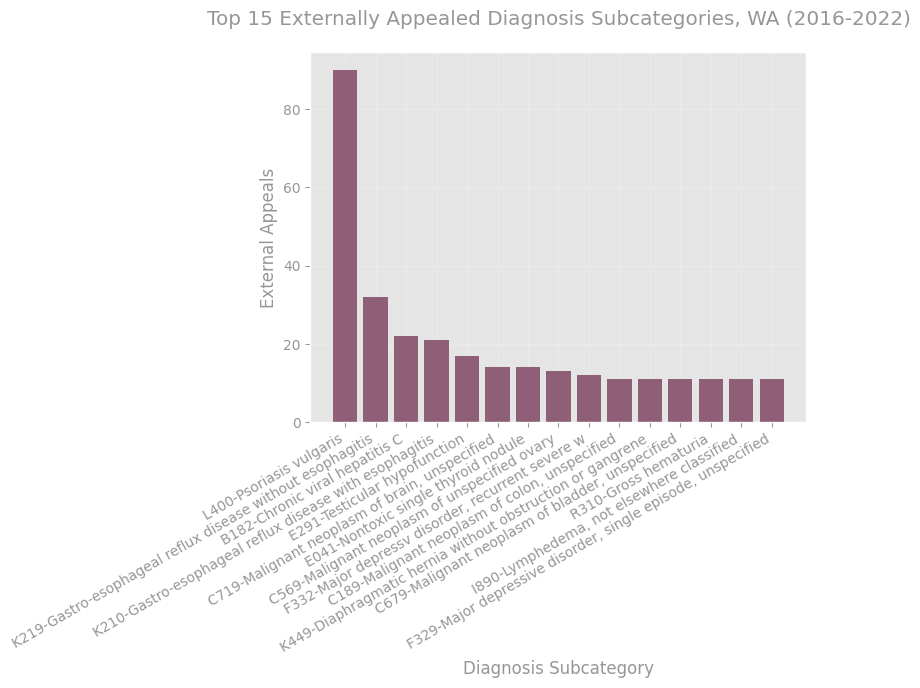

In [ ]:
# Diagnosis breakdowns
n = 15
title = f"Top {n} Externally Appealed Diagnosis Subcategories,\n WA (2016-2022)"
val_axis_label = "External Appeals"
cat_axis_label = "Diagnosis Subcategory"
subdiagnosis_val_counts = df["Diagnosis Subcategory"].value_counts()[:n]
bar_names, bar_vals = [
    x.strip("[").strip("]").split("/")[0] for x in list(subdiagnosis_val_counts.index)
], subdiagnosis_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(
        OUTPUT_IMAGE_DIR, "top_externally_appealed_diagnosis_subcategories.png"
    ),
    figsize=(10, 8),
    bar_label=True,
)

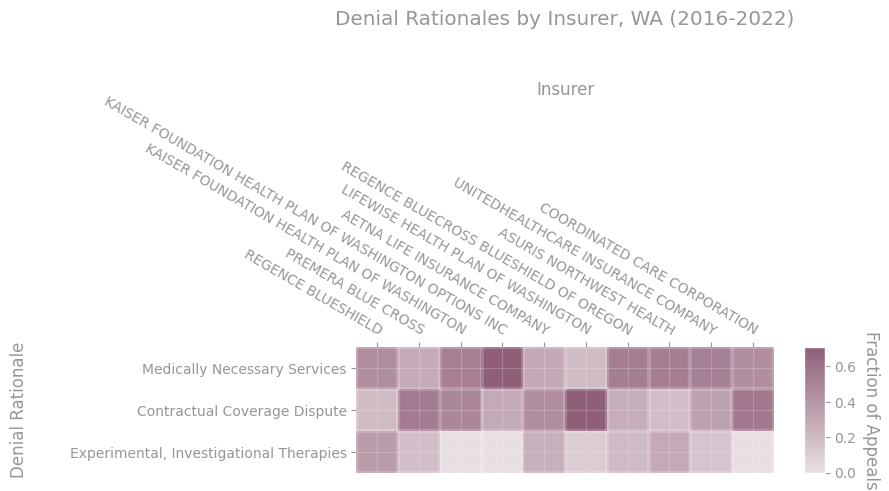

In [ ]:
heatmap_from_df_cols(
    df,
    col1="Reason for request",
    col2="CompanyName",
    top_k1=3,
    top_k2=10,
    heat_val_name="Fraction of Appeals",
    normalize=True,
    title="Denial Rationales by Insurer, WA (2016-2022)",
    x_label="Insurer",
    y_label="Denial Rationale",
    figsize=(9, 11),
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "denial_rationale_by_insurer.png"),
)

In [ ]:
agent_val_counts = df[REVIEW_ORG_COL].value_counts()
top_agent_val_counts = agent_val_counts[: len(agent_val_counts) // 2]
bottom_agent_val_counts = agent_val_counts[len(agent_val_counts) // 2 :]

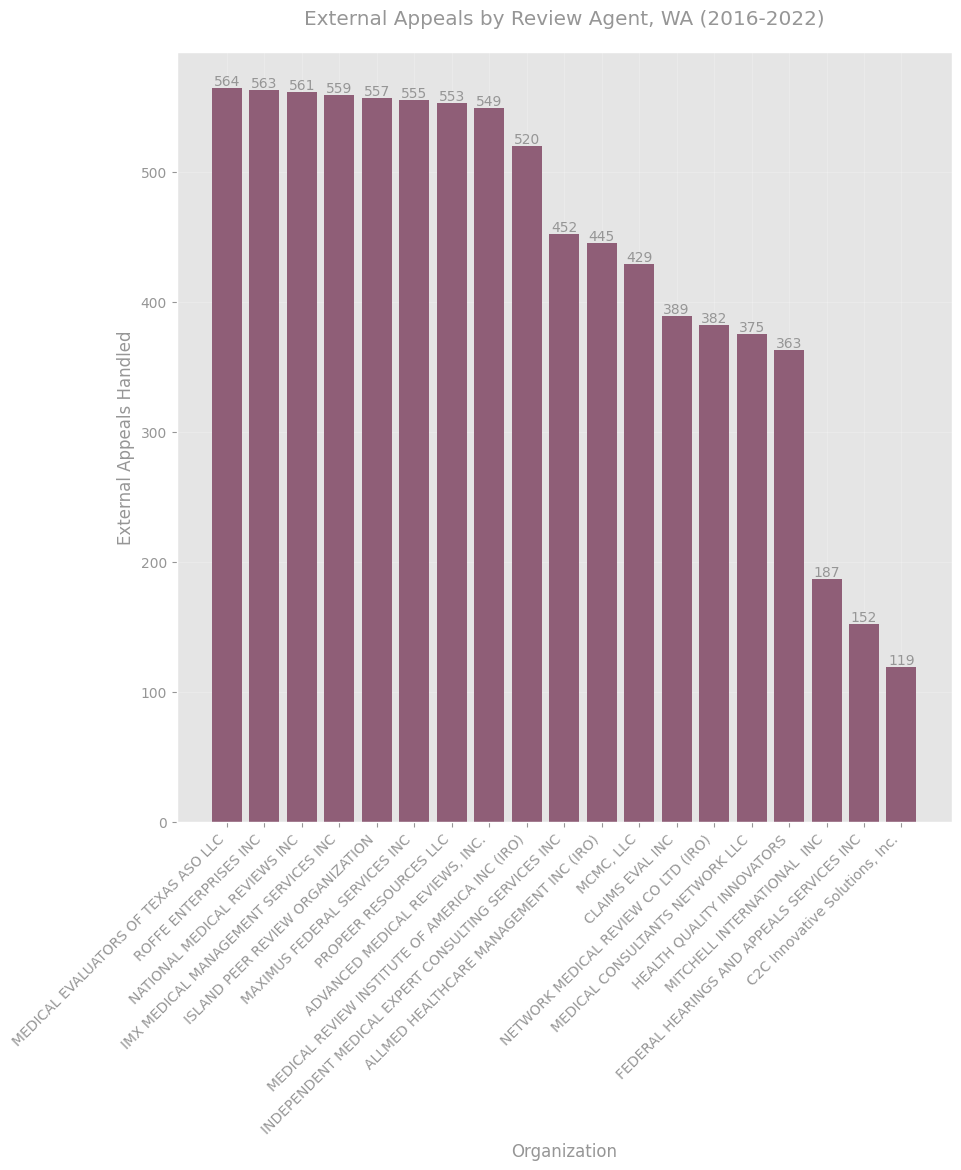

In [ ]:
# Agent breakdowns (top half)
title = "External Appeals by Review Agent, WA (2016-2022)"
val_axis_label = "External Appeals Handled"
cat_axis_label = "Organization"
bar_names, bar_vals = list(agent_val_counts.index), agent_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeals_by_agent.png"),
    bar_label=True,
    htick_rotation=45,
    figsize=(10, 10),
)

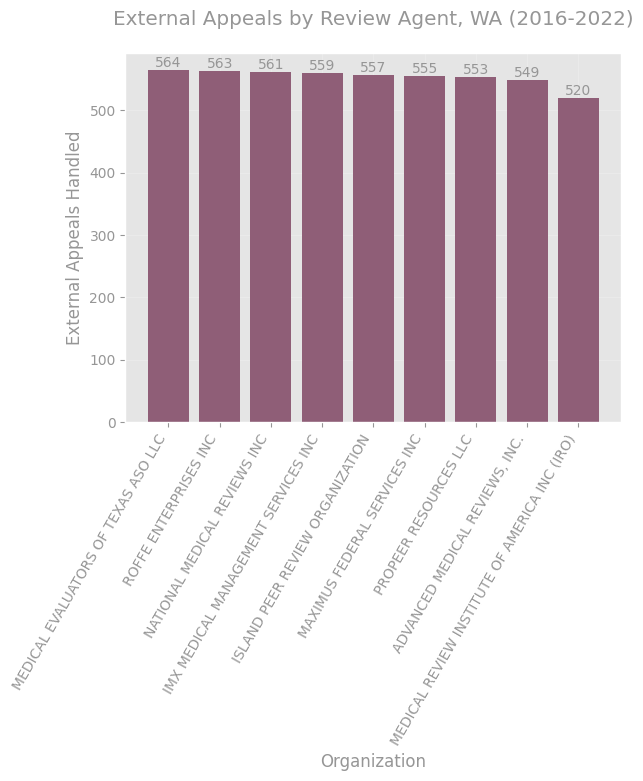

In [ ]:
# Agent breakdowns (bottom half)
title = "External Appeals by Review Agent, WA (2016-2022)"
val_axis_label = "External Appeals Handled"
cat_axis_label = "Organization"
bar_names, bar_vals = (
    list(top_agent_val_counts.index),
    top_agent_val_counts.values,
)
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeals_by_agent1.png"),
    bar_label=True,
    htick_rotation=60,
    figsize=(10, 8),
)

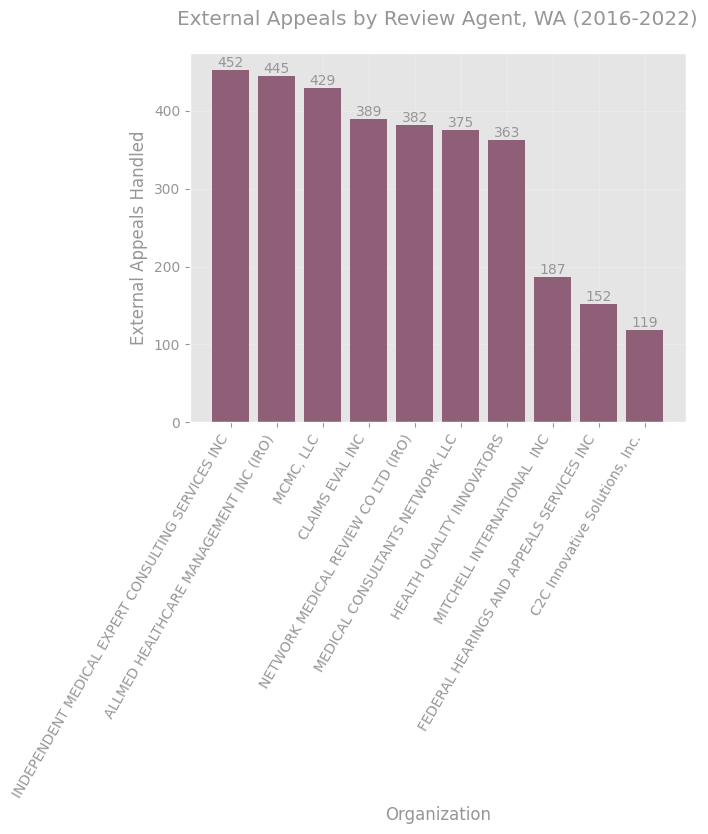

In [ ]:
# Agent breakdowns (bottom half)
title = "External Appeals by Review Agent, WA (2016-2022)"
val_axis_label = "External Appeals Handled"
cat_axis_label = "Organization"
bar_names, bar_vals = (
    list(bottom_agent_val_counts.index),
    bottom_agent_val_counts.values,
)
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeals_by_agent2.png"),
    bar_label=True,
    htick_rotation=60,
    figsize=(10, 8),
)

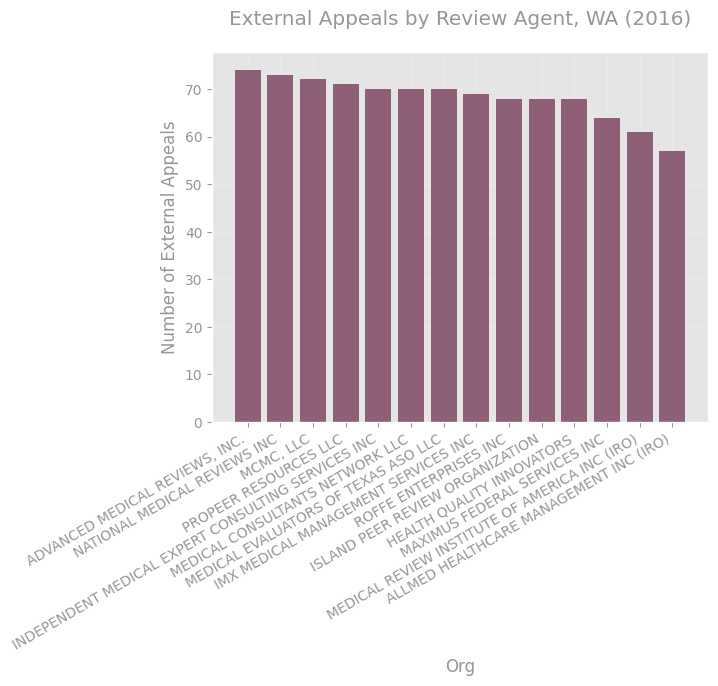

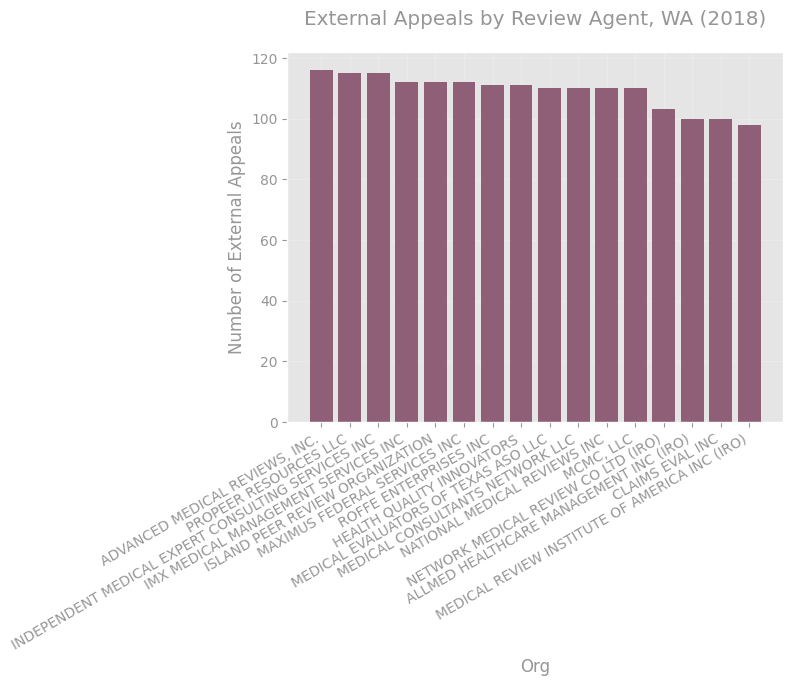

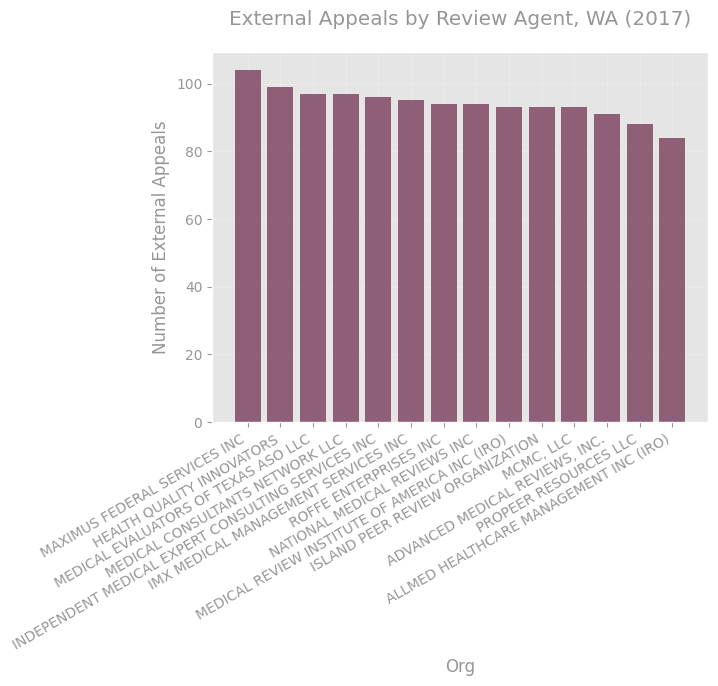

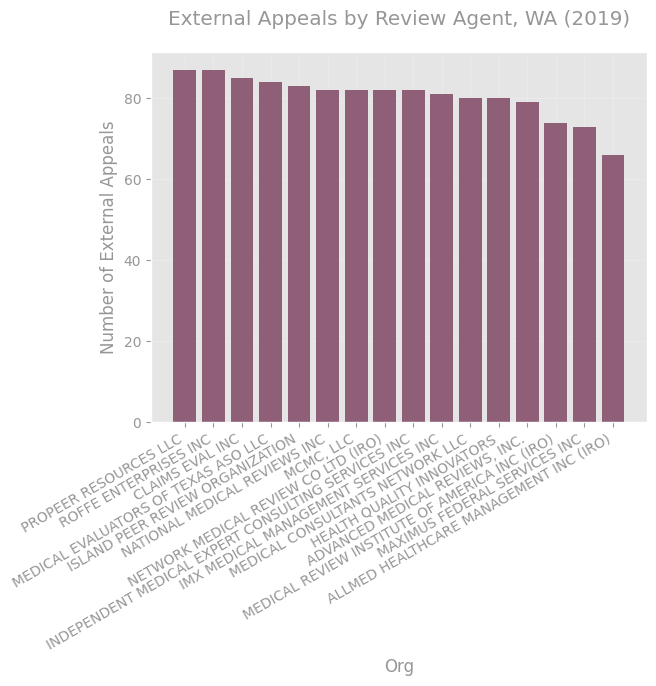

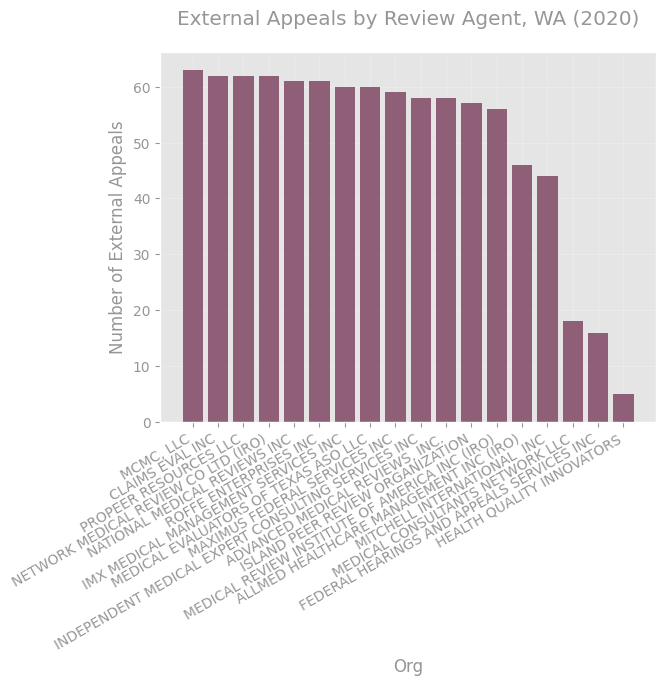

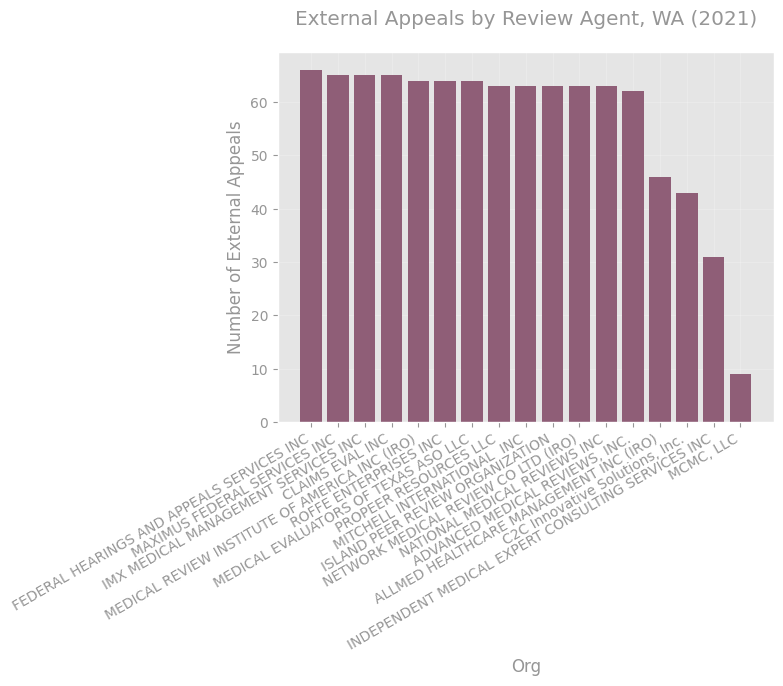

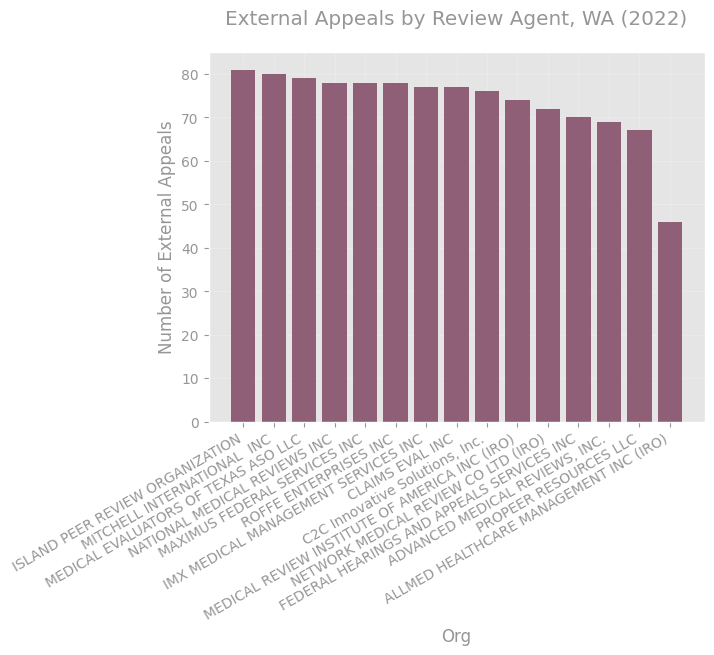

In [ ]:
# Agent breakdowns by year
for year in df[YEAR_COL].unique():
    rel_df = df[df[YEAR_COL] == year]
    year_agent_val_counts = rel_df[REVIEW_ORG_COL].value_counts()
    title = f"External Appeals by Review Agent, WA ({year})"
    val_axis_label = "Number of External Appeals"
    cat_axis_label = "Org"
    bar_names, bar_vals = (
        list(year_agent_val_counts.index),
        year_agent_val_counts.values,
    )
    plot_bar(
        bar_names,
        bar_vals,
        title=title,
        val_axis_label=val_axis_label,
        cat_axis_label=cat_axis_label,
        save_path=os.path.join(
            OUTPUT_IMAGE_DIR, f"external_appeals_by_agent_{year}.png"
        ),
        show=False,
        bar_label=True,
        figsize=(10, 8),
    )

In [ ]:
agent_decision_data = get_overturn_rates_by_category(
    df, cat_col=REVIEW_ORG_COL, by_year=True
)

In [ ]:
agent_decision_data = {
    k: v for k, v in agent_decision_data.items() if k in agent_val_counts.index
}

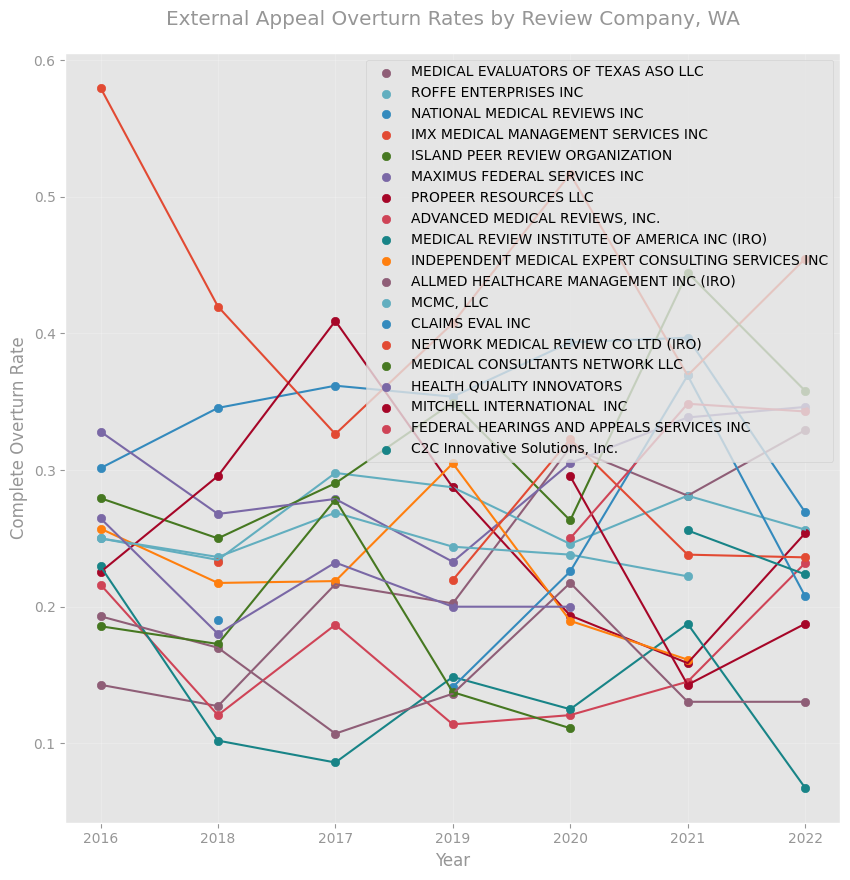

In [ ]:
# Plot agent decision rates over time
fig, ax = plt.subplots(figsize=(10, 10))
x = list(df[YEAR_COL].unique())
ax.set_title("External Appeal Overturn Rates by Review Company, WA")
ax.set_ylabel("Complete Overturn Rate")
ax.set_xlabel("Year")
dates = np.asarray(x).astype(str)
for agent in agent_val_counts.keys():
    agent_timeseries = []
    for year in x:
        if agent_decision_data[agent].get(year, None):
            agent_timeseries.append(agent_decision_data[agent][year]["overturn_rate"])
        else:
            agent_timeseries.append(None)
    ax.scatter(dates, agent_timeseries, label=agent)
    ax.plot(dates, agent_timeseries)
ax.legend(labelcolor="black")
save_path = os.path.join(
    OUTPUT_IMAGE_DIR, "external_appeal_overturn_rates_by_review_org.png"
)
plt.savefig(save_path, transparent=True, bbox_inches="tight")
plt.show()

In [ ]:
bar_vals = []
bar_names = []
for agent in top_agent_val_counts.keys():
    bar_names.append(agent)
    bar_vals.append(agent_decision_data[agent]["overall"]["overturn_rate"])

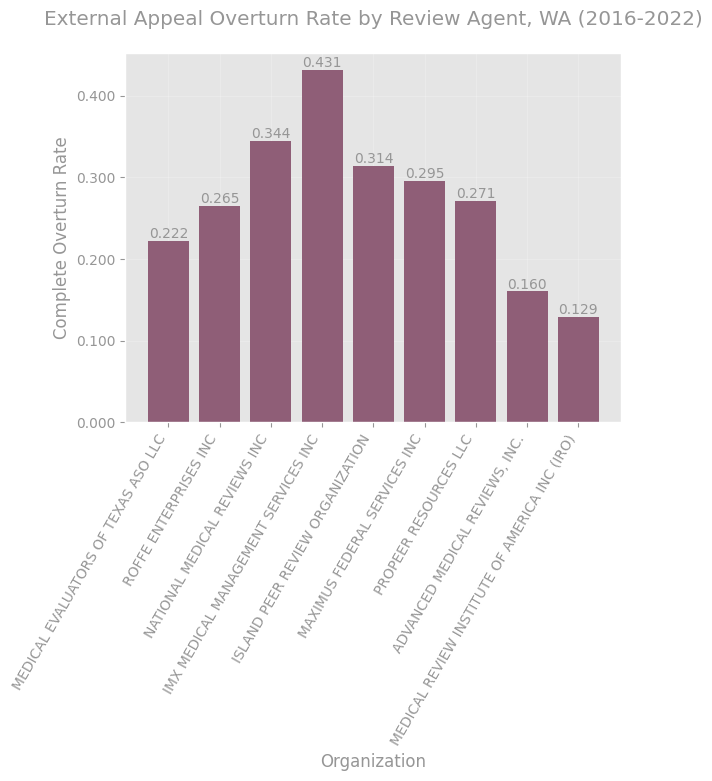

In [ ]:
# Agent breakdowns overturn rates (averaged over years)
title = "External Appeal Overturn Rate by Review Agent,\n WA (2016-2022)"
val_axis_label = "Complete Overturn Rate"
cat_axis_label = "Organization"
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(
        OUTPUT_IMAGE_DIR, "external_appeal_overturn_rates_by_agent.png"
    ),
    bar_label=True,
    int_vals=False,
    htick_rotation=60,
    figsize=(10, 8),
)

Q: Who funds each of these orgs? How much money does each receive from services they sell to insurers, and how, if at all,
does that relate to their historical overturn rates?

### NMN / Experimental Specific Counts

In [ ]:
# NMN / Experimental / Contractual
RATIONALE_CAT = "Reason for request"
rationale_df = df[~df[RATIONALE_CAT].isna()].copy()
rationale_decision_data = get_overturn_rates_by_category(
    rationale_df, RATIONALE_CAT, by_year=True
)

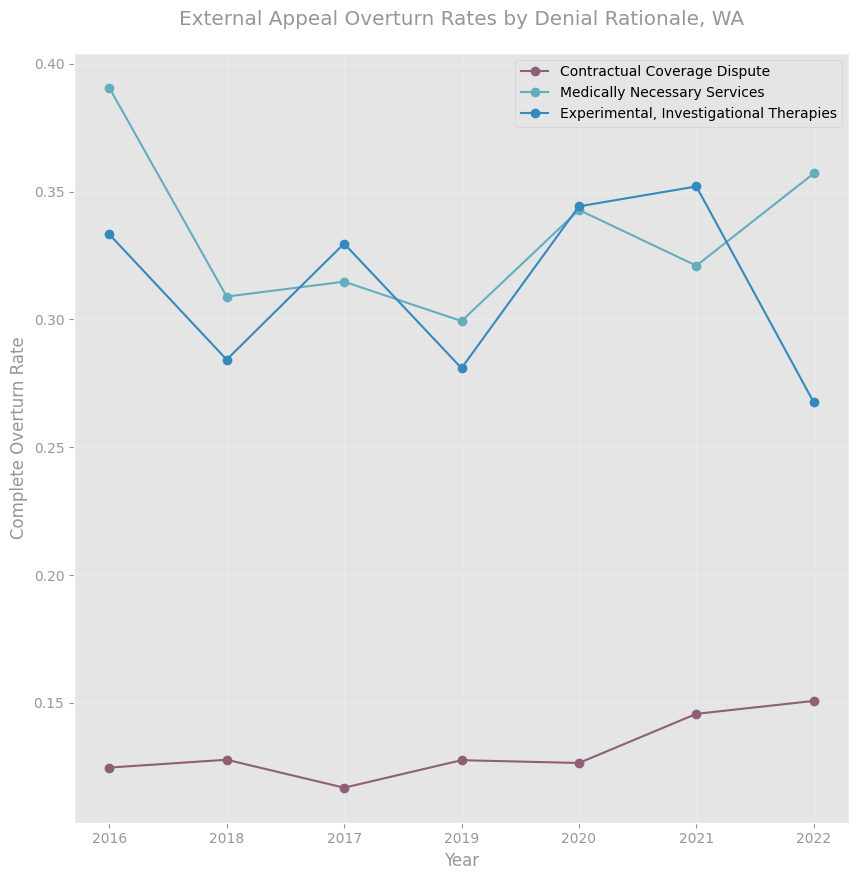

In [ ]:
# Change over years
fig, ax = plt.subplots(figsize=(10, 10))
rationales = list(rationale_df[RATIONALE_CAT].unique())

ax.set_title("External Appeal Overturn Rates by Denial Rationale, WA")
ax.set_ylabel("Complete Overturn Rate")
ax.set_xlabel("Year")
years = list(df[YEAR_COL].unique())
dates = np.asarray(years).astype(str)
for rationale in rationales:
    decision_data = rationale_decision_data[rationale]
    timeseries = []
    for year in years:
        if decision_data.get(year, None):
            timeseries.append(decision_data[year]["overturn_rate"])
        else:
            timeseries.append(None)
    ax.plot(dates, timeseries, "o-", label=rationale)

ax.legend(labelcolor="black")
save_path = os.path.join(
    OUTPUT_IMAGE_DIR, "external_appeal_overturn_rates_by_denial_rationale_by_year.png"
)
plt.savefig(save_path, transparent=True, bbox_inches="tight")
plt.show()

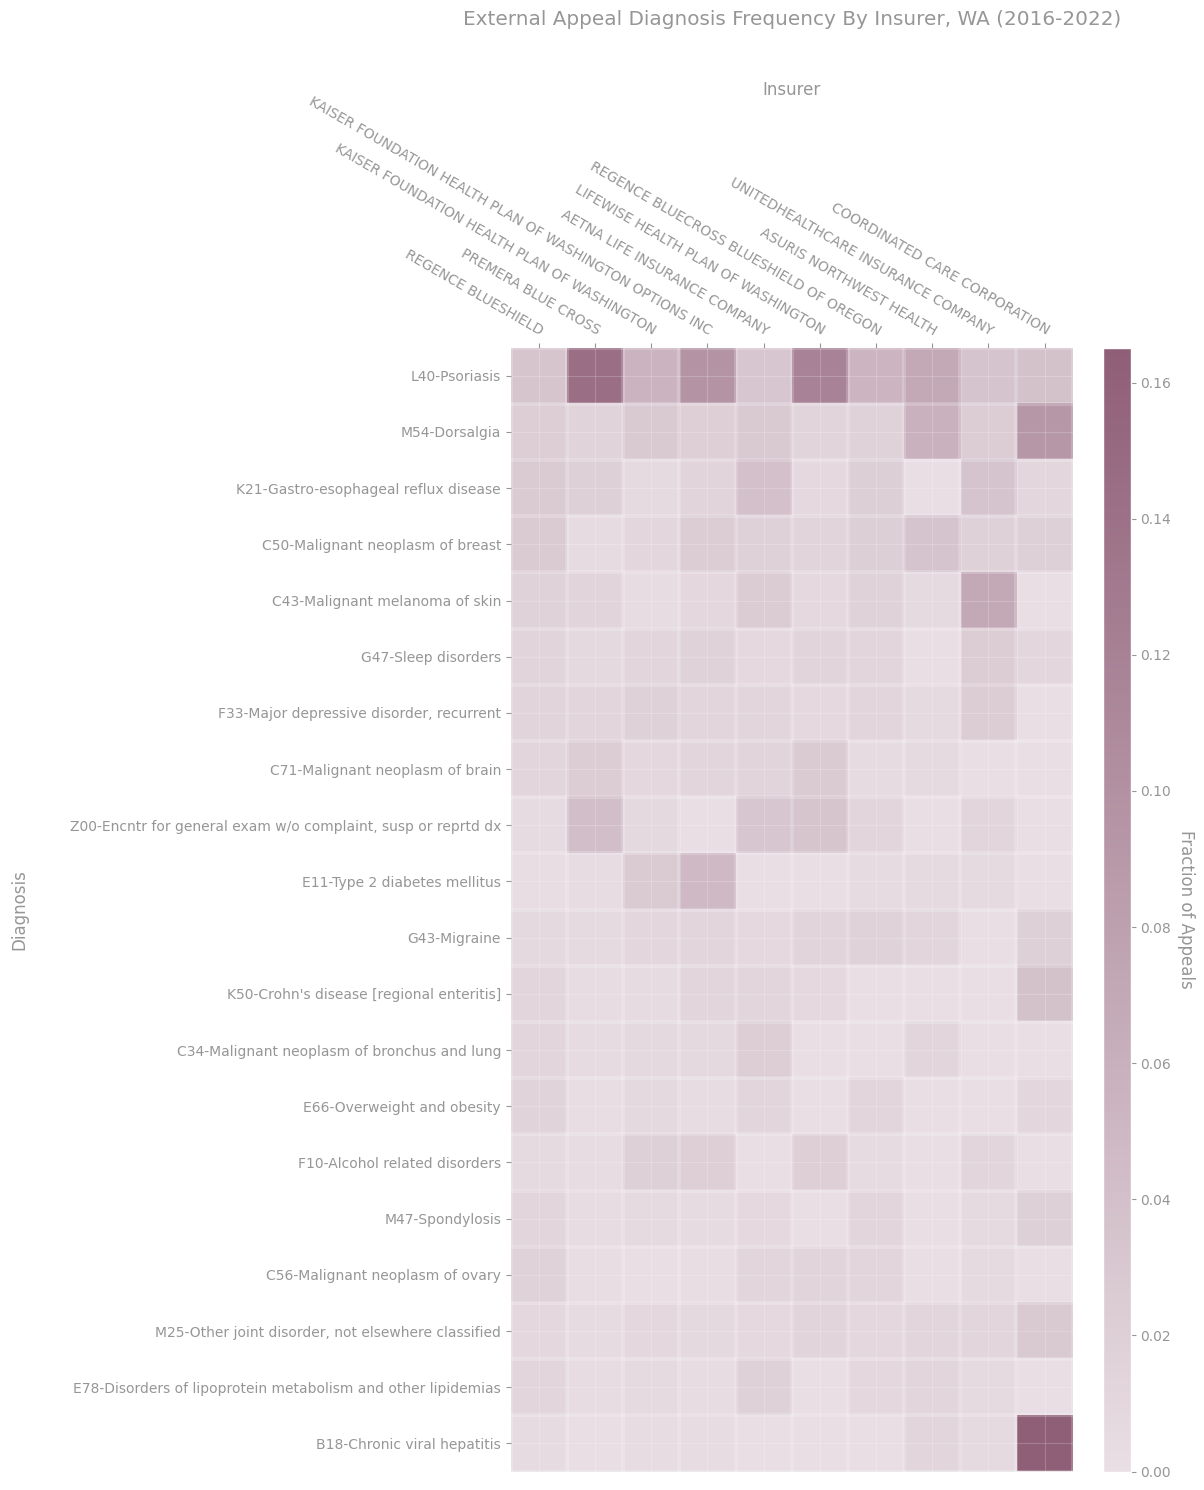

In [ ]:
heatmap_from_df_cols(
    df,
    col1="Diagnosis",
    col2="CompanyName",
    top_k1=20,
    top_k2=10,
    heat_val_name="Fraction of Appeals",
    normalize=True,
    title="External Appeal Diagnosis Frequency By Insurer, WA (2016-2022)",
    x_label="Insurer",
    y_label="Diagnosis",
    figsize=(12, 15),
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "diagnosis_by_insurer.png"),
)

In [ ]:
overturns = df[df["Outcome"] == "Overturned"]

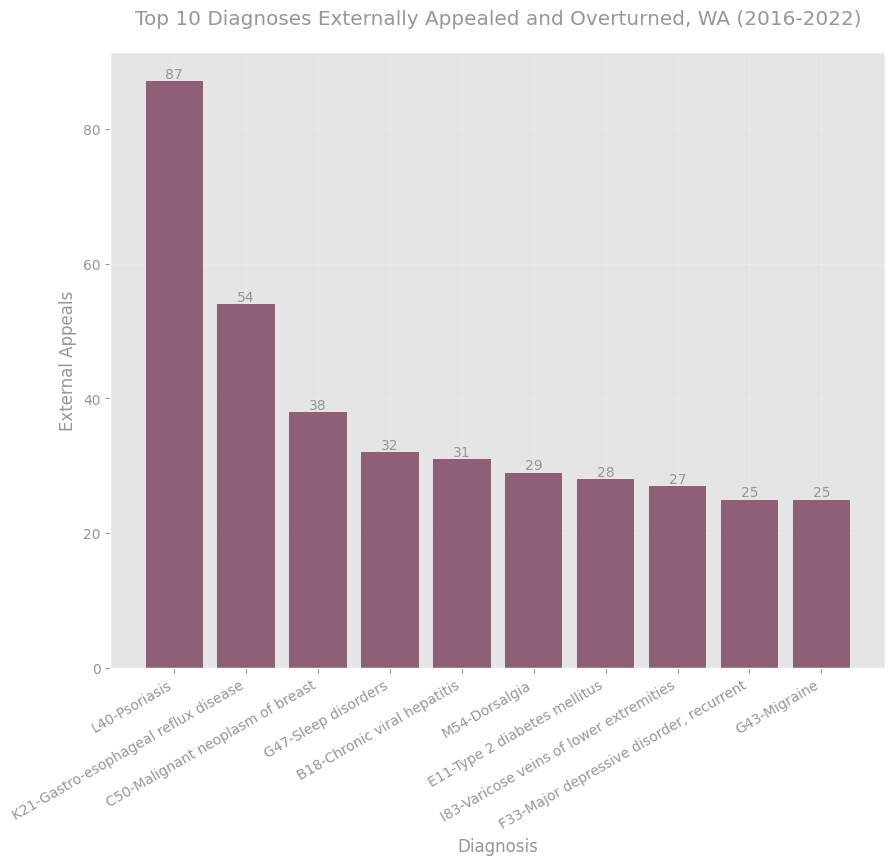

In [ ]:
# Diagnosis breakdowns among overturns
n = 10
title = f"Top {n} Diagnoses Externally Appealed and Overturned,\n WA (2016-2022)"
val_axis_label = "External Appeals"
cat_axis_label = "Diagnosis"
diagnosis_val_counts = overturns["Diagnosis"].value_counts()[:n]
bar_names, bar_vals = [
    x.strip("[").strip("]").split("/")[0] for x in list(diagnosis_val_counts.index)
], diagnosis_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "top_overturned_diagnoses.png"),
    bar_label=True,
    figsize=(10, 8),
)

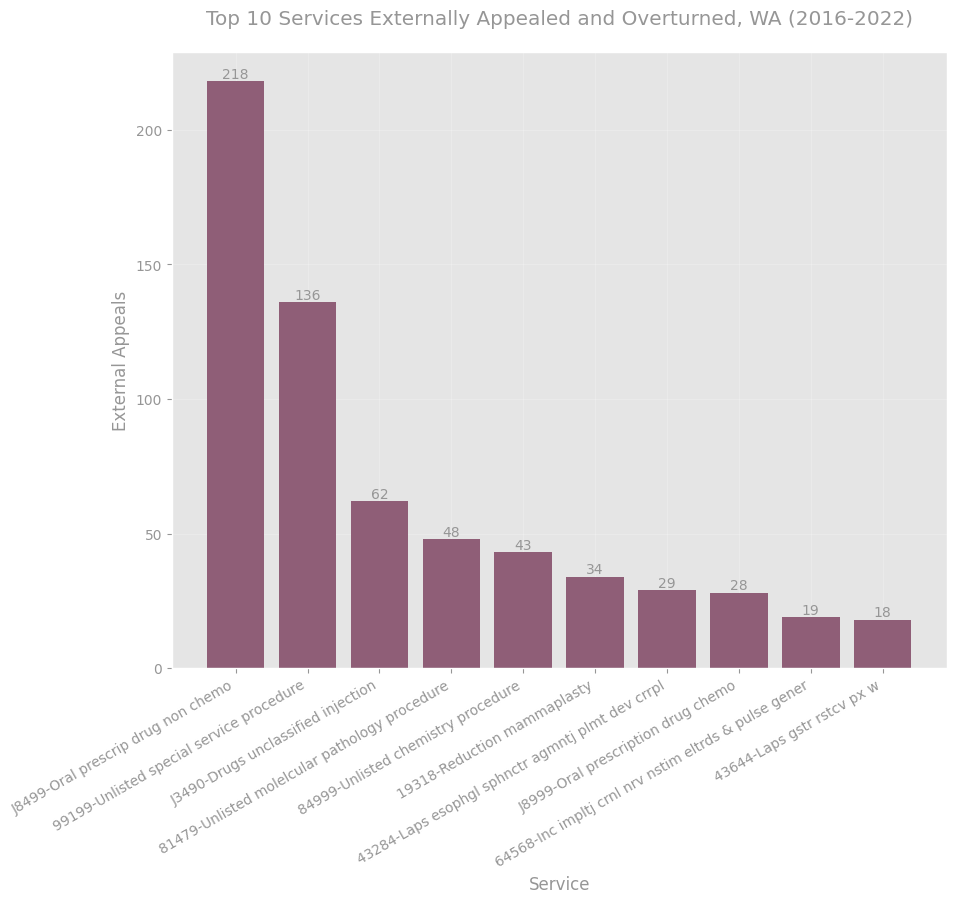

In [ ]:
# Treatment breakdowns (via HCPCS identifiers)
n = 10
title = f"Top {n} Services\n Externally Appealed and Overturned,\n WA (2016-2022)"
val_axis_label = "External Appeals"
cat_axis_label = "Service"
treatment_val_counts = overturns["Treatment"].value_counts()[:n]
bar_names, bar_vals = [
    x.strip("[").strip("]").split("/")[0] for x in list(treatment_val_counts.index)
], treatment_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "top_overturned_services.png"),
    bar_label=True,
    figsize=(10, 8),
)

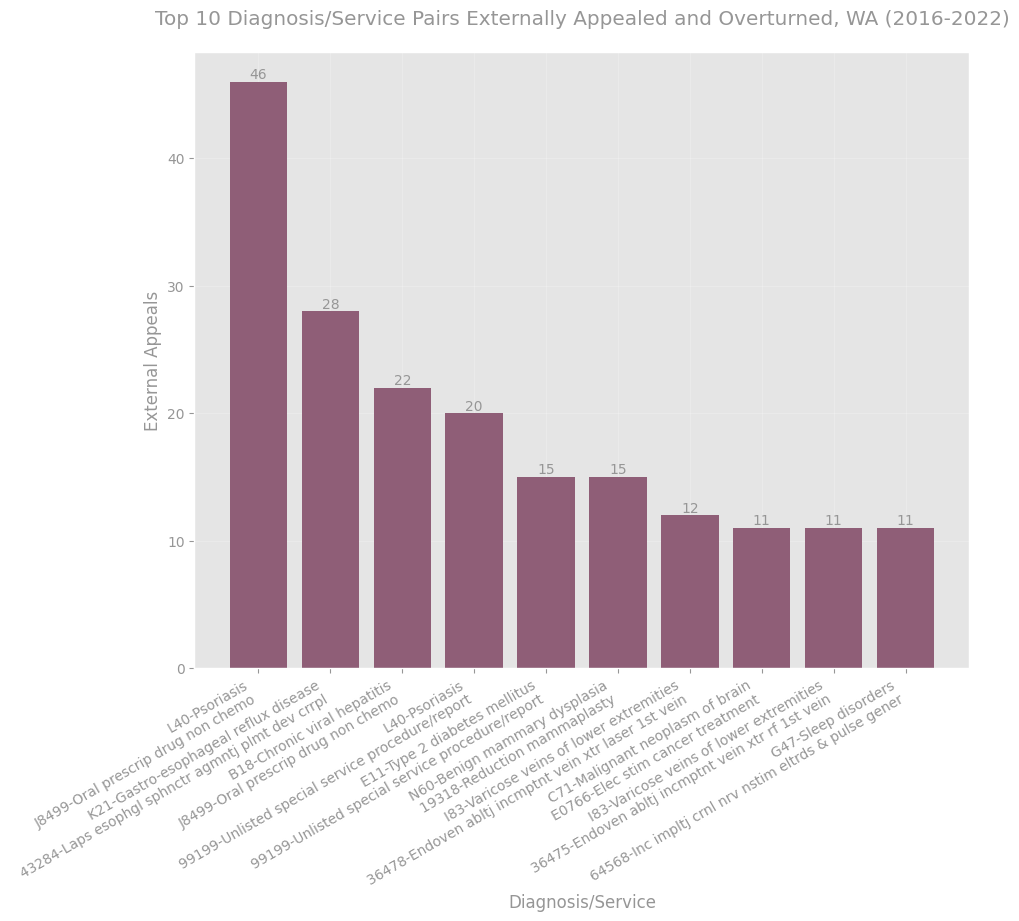

In [ ]:
# Treatment breakdowns (via HCPCS identifiers)
n = 10
title = f"Top {n} Diagnosis/Service Pairs\n Externally Appealed and Overturned,\n WA (2016-2022)"
val_axis_label = "External Appeals"
cat_axis_label = "Diagnosis/Service"
diag_treat_pairs = (
    overturns.groupby(["Diagnosis", "Treatment"], as_index=False)
    .size()
    .sort_values(by="size", ascending=False)[:n]
)
bar_names, bar_vals = [
    x[0] + "\n" + x[1]
    for x in zip(
        diag_treat_pairs["Diagnosis"].values, diag_treat_pairs["Treatment"].values
    )
], diag_treat_pairs["size"].values
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "top_overturned_diag_services.png"),
    bar_label=True,
    figsize=(10, 8),
)

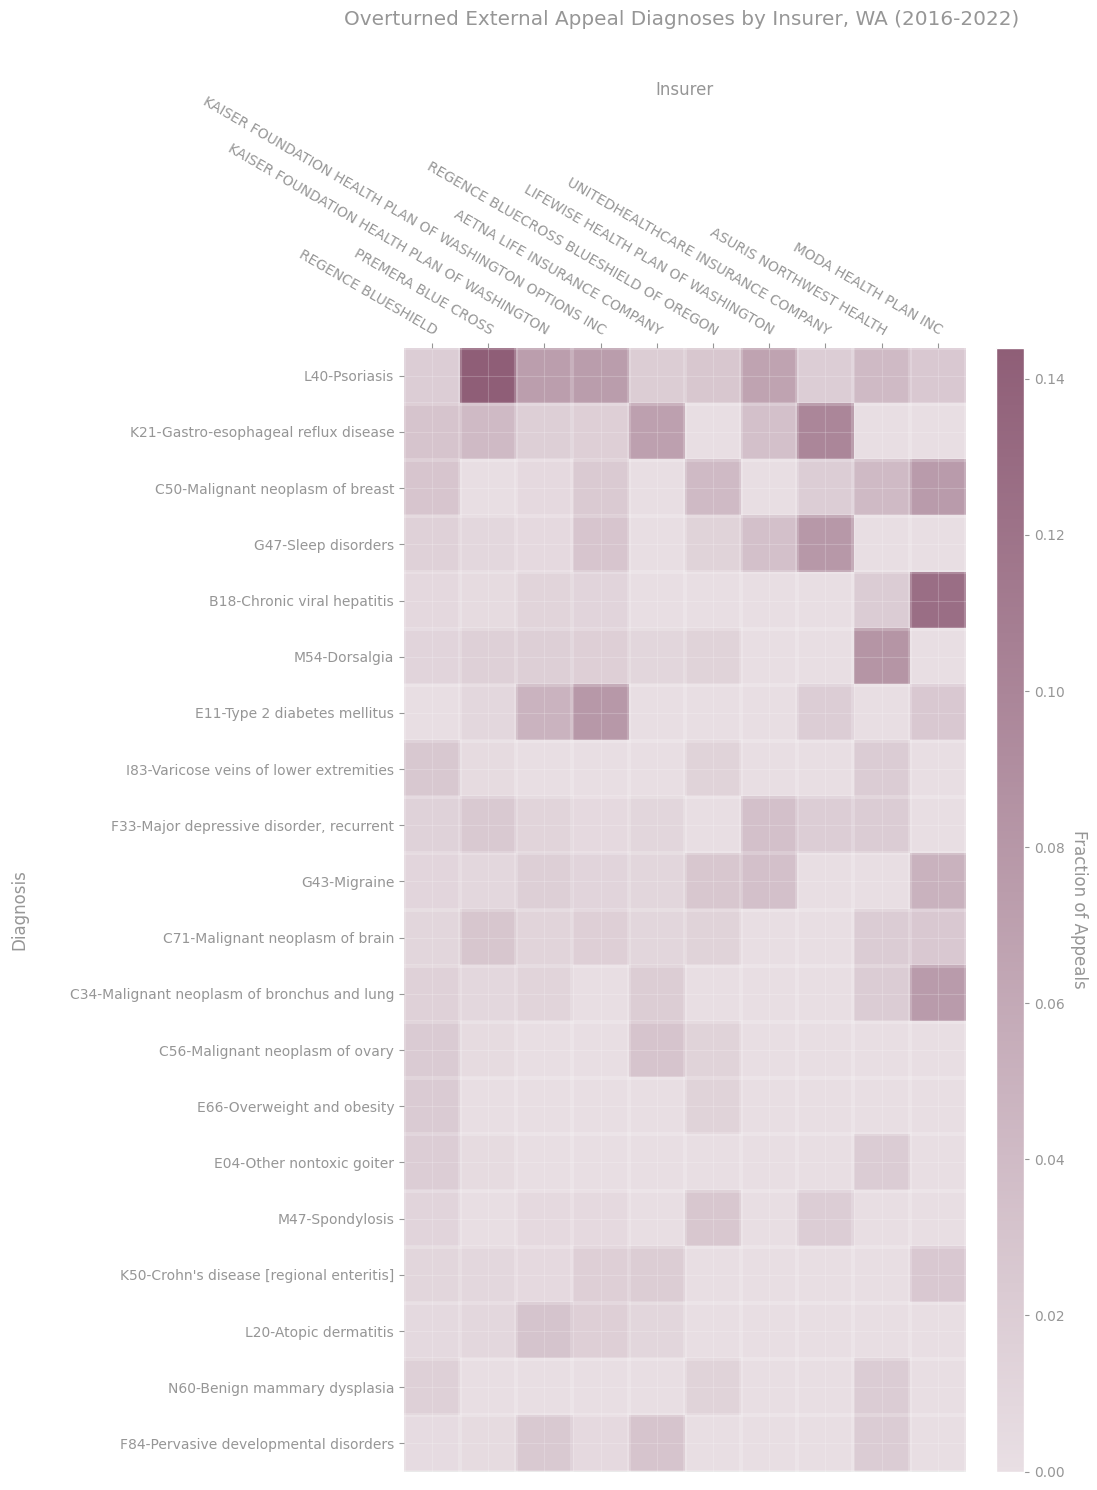

In [ ]:
heatmap_from_df_cols(
    overturns,
    col1="Diagnosis",
    col2="CompanyName",
    top_k1=20,
    top_k2=10,
    heat_val_name="Fraction of Appeals",
    normalize=True,
    title="Overturned External Appeal Diagnoses by Insurer,\n WA (2016-2022) ",
    x_label="Insurer",
    y_label="Diagnosis",
    figsize=(12, 15),
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "overturned_diagnosis_by_insurer.png"),
)

In [ ]:
nmn = df[df["Reason for request"] == "Medically Necessary Services"]
experimental = df[df["Reason for request"] == "Experimental, Investigational Therapies"]
contractual = df[df["Reason for request"] == "Contractual Coverage Dispute"]

overturned_nmn = nmn[nmn["Outcome"] == "Overturned"]
overturned_experimental = experimental[experimental["Outcome"] == "Overturned"]
overturned_contractual = contractual[contractual["Outcome"] == "Overturned"]

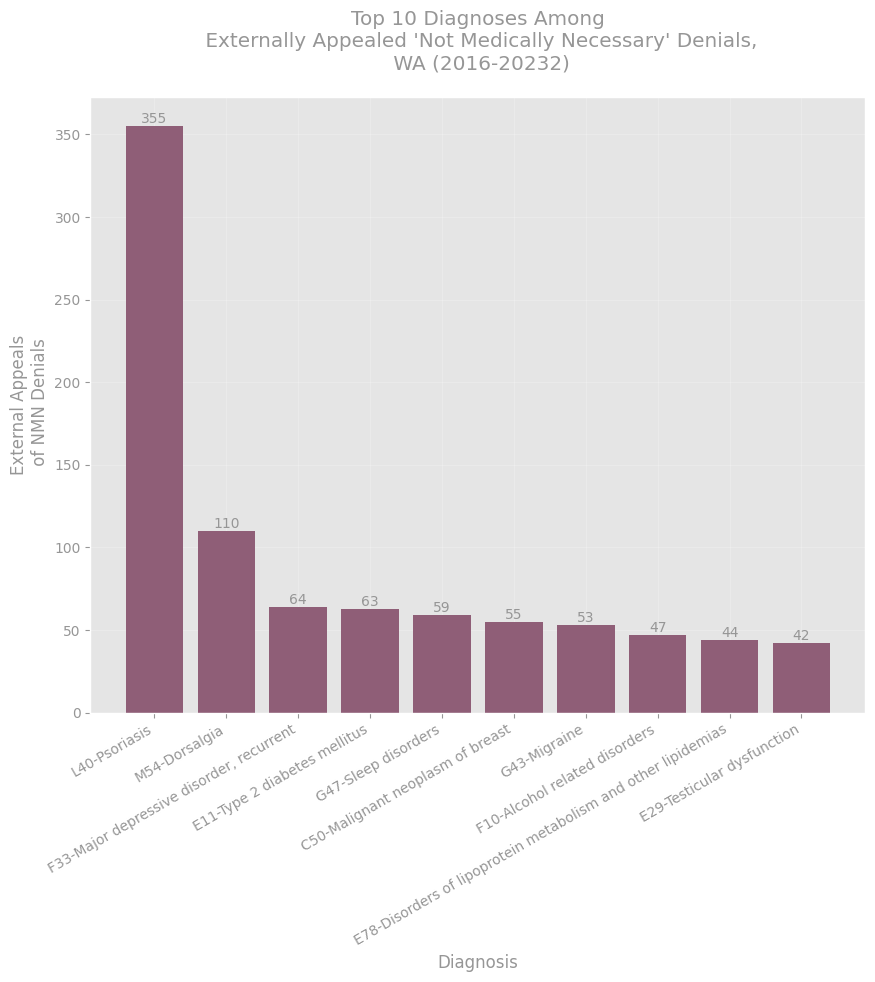

In [ ]:
# Diagnosis breakdowns among NMN
n = 10
title = f"Top {n} Diagnoses Among\n Externally Appealed 'Not Medically Necessary' Denials,\n WA (2016-20232)"
val_axis_label = "External Appeals\n of NMN Denials"
cat_axis_label = "Diagnosis"
diagnosis_val_counts = nmn["Diagnosis"].value_counts()[:n]
bar_names, bar_vals = [
    x.strip("[").strip("]").split("/")[0] for x in list(diagnosis_val_counts.index)
], diagnosis_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "top_nmm_appeal_diagnoses.png"),
    figsize=(10, 8),
    bar_label=True,
)

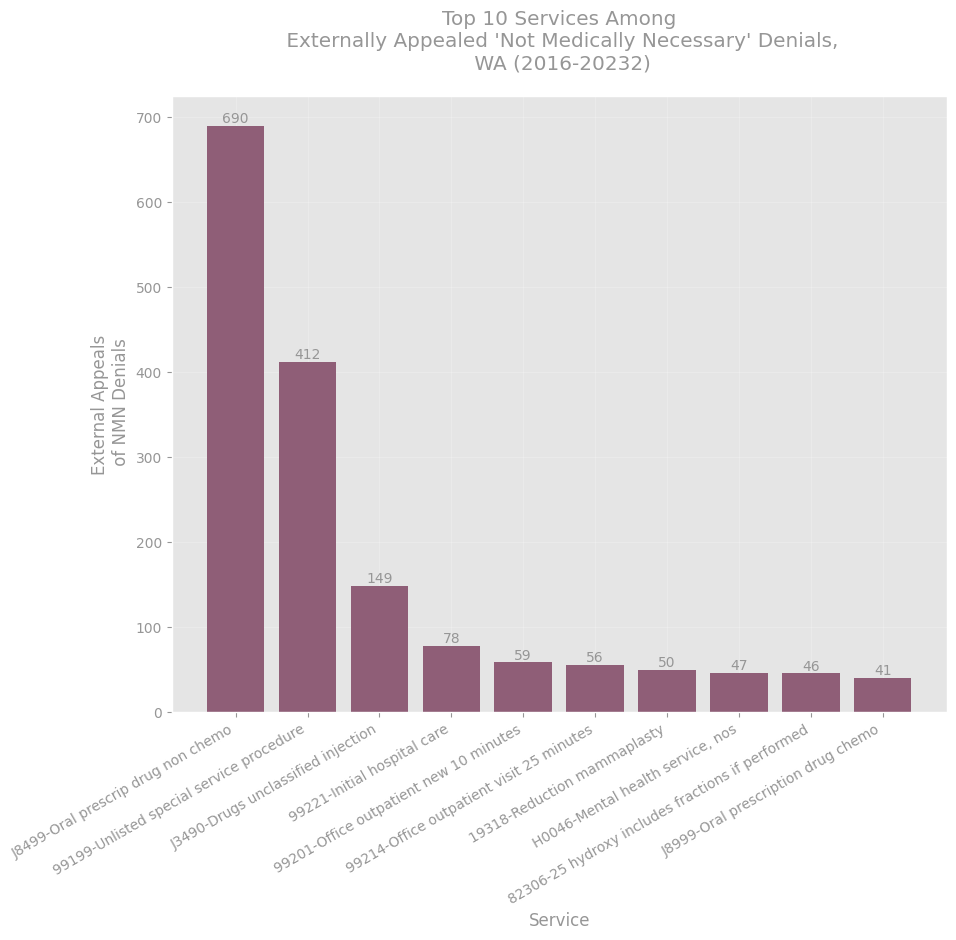

In [ ]:
# Service breakdowns among NMN
n = 10
title = f"Top {n} Services Among\n Externally Appealed 'Not Medically Necessary' Denials,\n WA (2016-20232)"
val_axis_label = "External Appeals\n of NMN Denials"
cat_axis_label = "Service"
service_val_counts = nmn["Treatment"].value_counts()[:n]
bar_names, bar_vals = [
    x.strip("[").strip("]").split("/")[0] for x in list(service_val_counts.index)
], service_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "top_nmm_appeal_services.png"),
    figsize=(10, 8),
    bar_label=True,
)

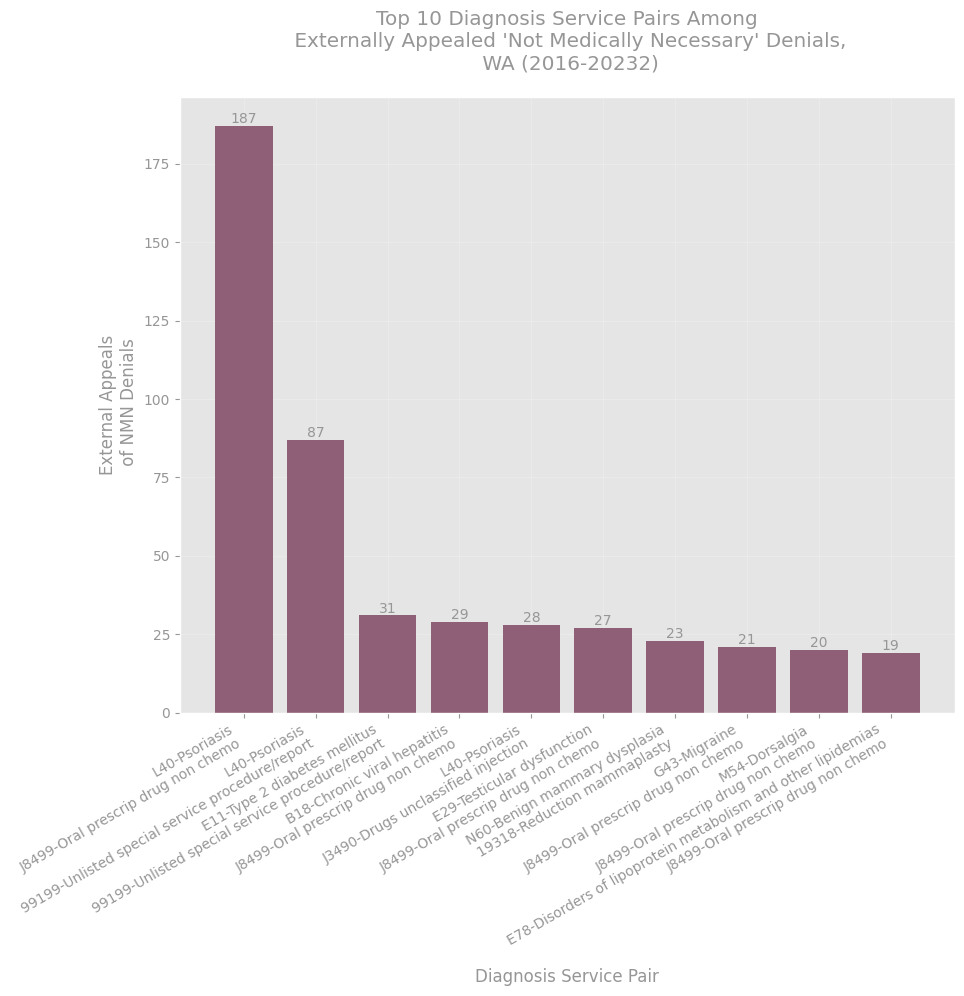

In [ ]:
# Diagnosis/Service breakdowns among NMN
n = 10
title = f"Top {n} Diagnosis Service Pairs Among\n Externally Appealed 'Not Medically Necessary' Denials,\n WA (2016-20232)"
val_axis_label = "External Appeals\n of NMN Denials"
cat_axis_label = "Diagnosis Service Pair"
diag_treat_pairs = (
    nmn.groupby(["Diagnosis", "Treatment"], as_index=False)
    .size()
    .sort_values(by="size", ascending=False)[:n]
)
bar_names, bar_vals = [
    x[0] + "\n" + x[1]
    for x in zip(
        diag_treat_pairs["Diagnosis"].values, diag_treat_pairs["Treatment"].values
    )
], diag_treat_pairs["size"].values
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "top_nmm_appeal_diag_service.png"),
    figsize=(10, 8),
    bar_label=True,
)

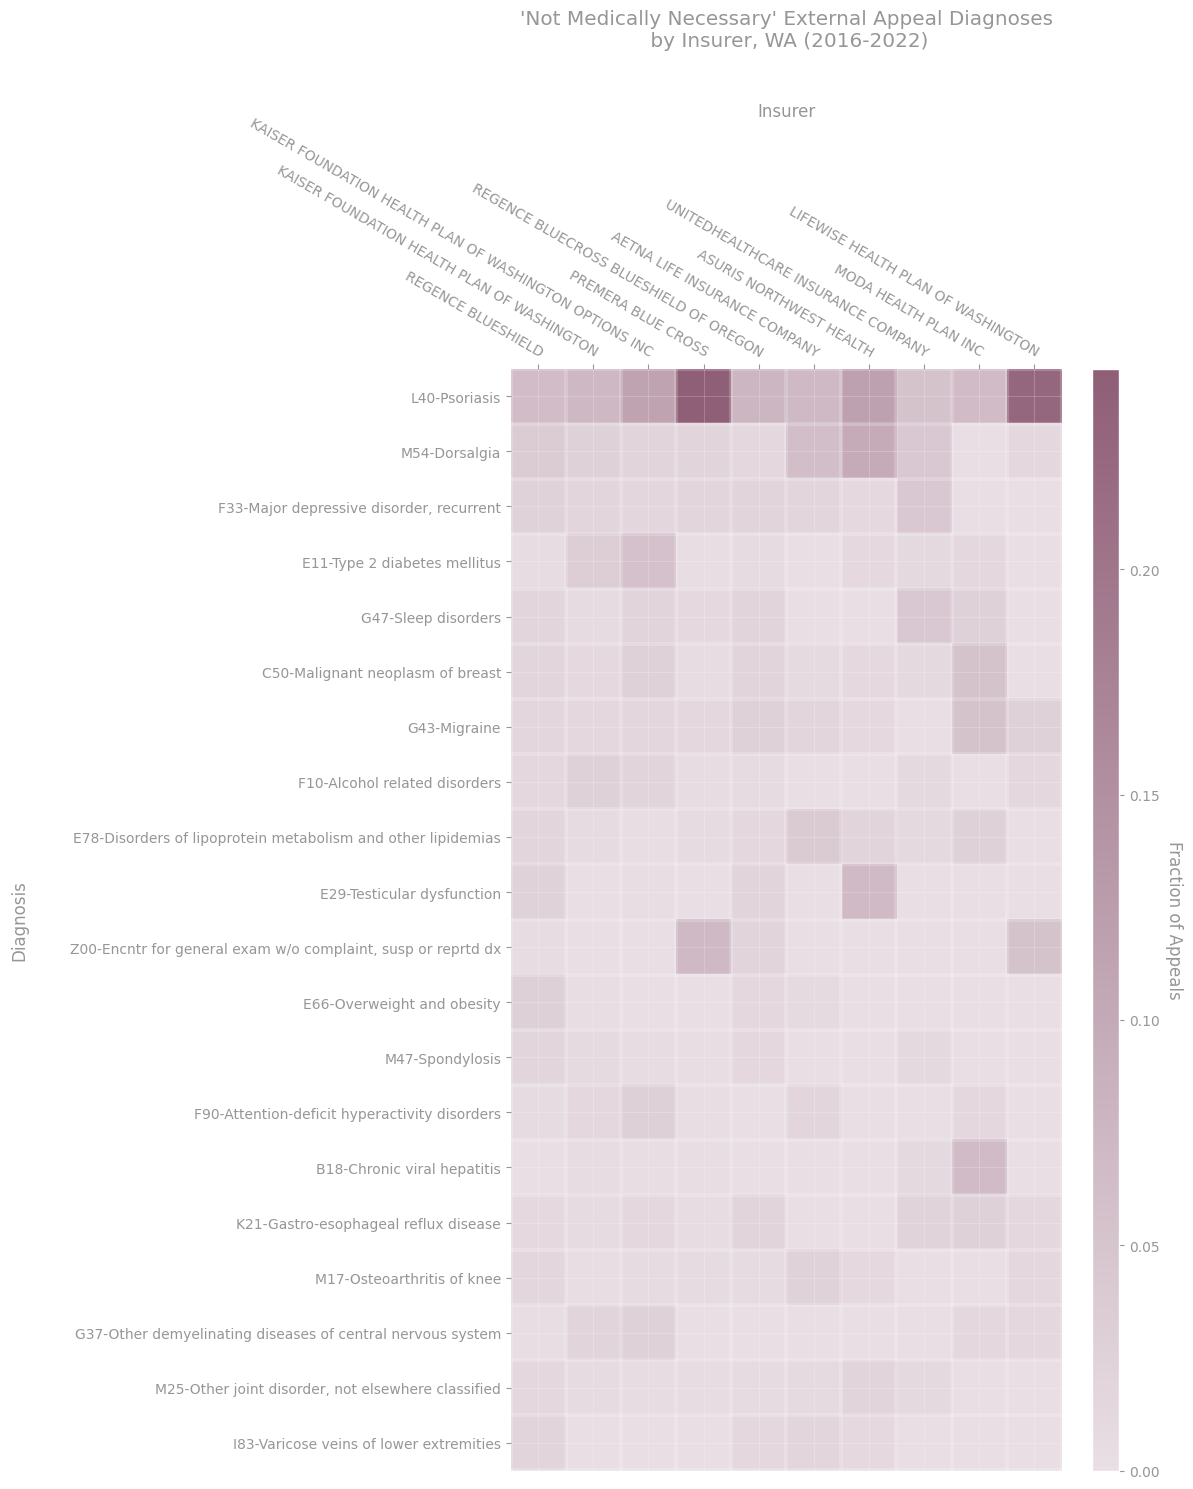

In [ ]:
heatmap_from_df_cols(
    nmn,
    col1="Diagnosis",
    col2="CompanyName",
    top_k1=20,
    top_k2=10,
    heat_val_name="Fraction of Appeals",
    normalize=True,
    title="'Not Medically Necessary' External Appeal Diagnoses\n by Insurer, WA (2016-2022)",
    x_label="Insurer",
    y_label="Diagnosis",
    figsize=(12, 15),
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "nmn_diagnosis_by_insurer.png"),
)

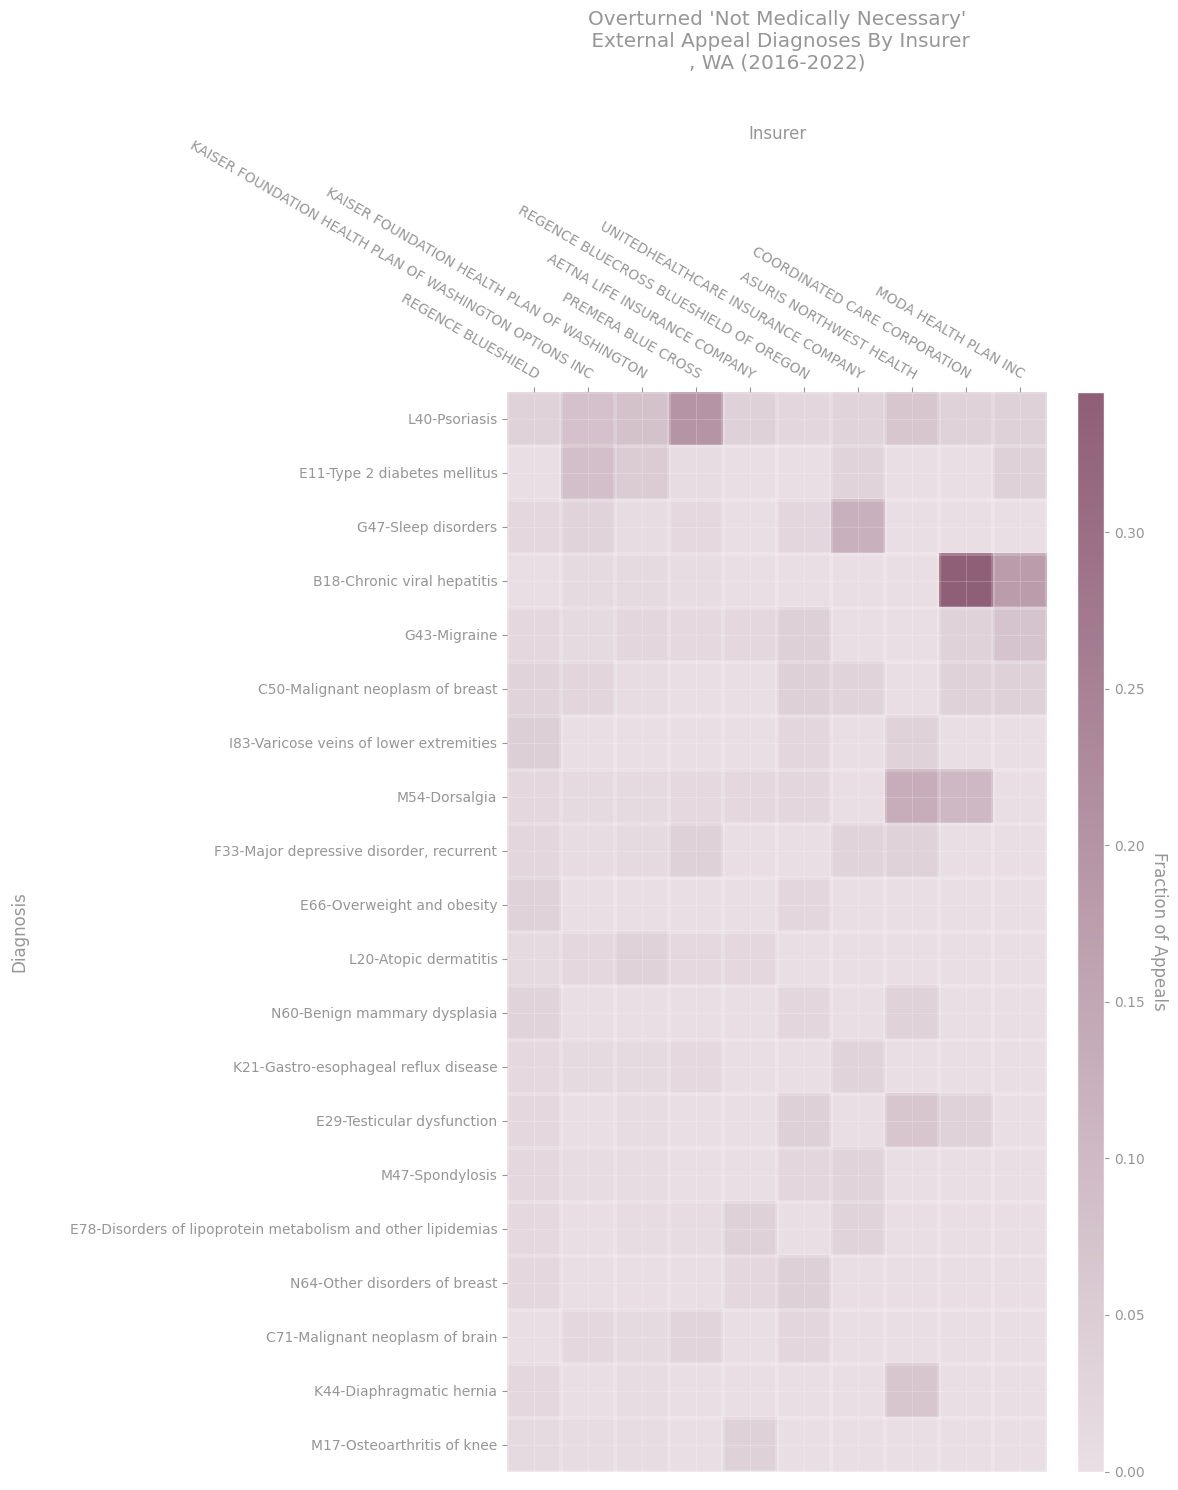

In [ ]:
heatmap_from_df_cols(
    overturned_nmn,
    col1="Diagnosis",
    col2="CompanyName",
    top_k1=20,
    top_k2=10,
    heat_val_name="Fraction of Appeals",
    normalize=True,
    title="Overturned 'Not Medically Necessary'\n External Appeal Diagnoses By Insurer,\n WA (2016-2022)",
    x_label="Insurer",
    y_label="Diagnosis",
    figsize=(12, 15),
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "nmn_overturned_diagnosis_by_insurer.png"),
)

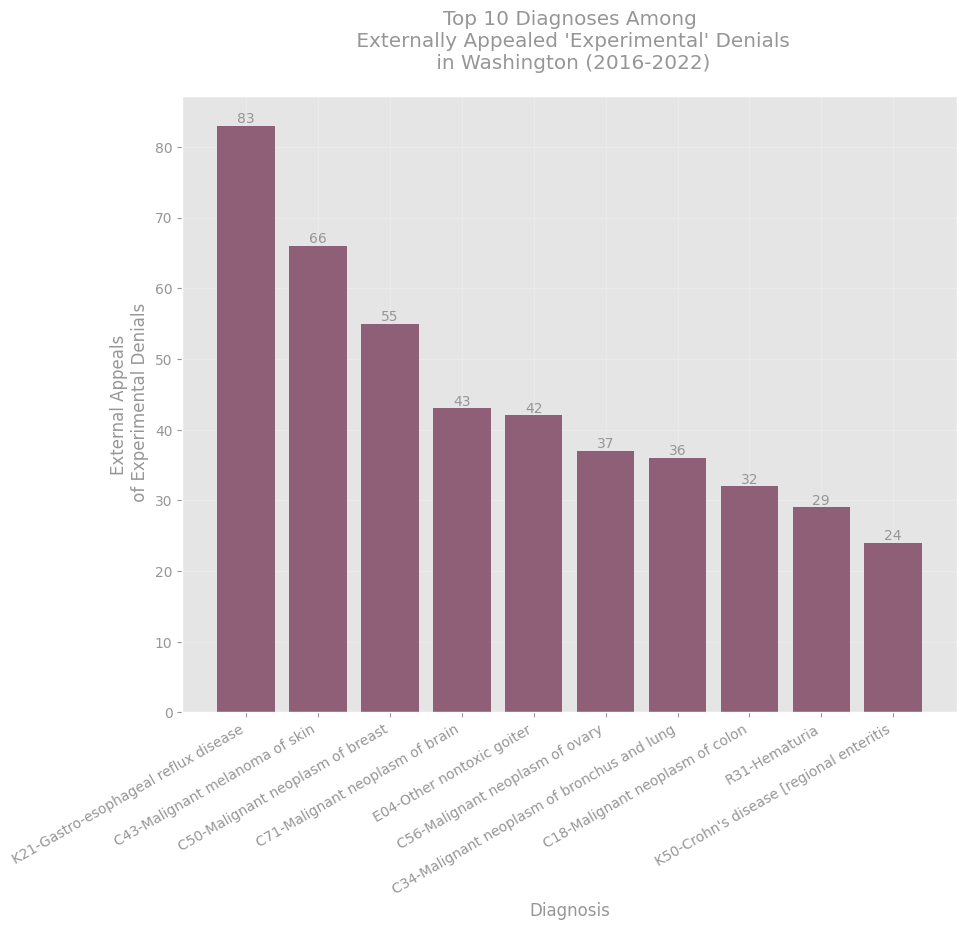

In [ ]:
# Diagnosis breakdowns among Experimental Denials
n = 10
title = f"Top {n} Diagnoses Among\n Externally Appealed 'Experimental' Denials\n in Washington (2016-2022)"
val_axis_label = "External Appeals\n of Experimental Denials"
cat_axis_label = "Diagnosis"
diagnosis_val_counts = experimental["Diagnosis"].value_counts()[:n]
bar_names, bar_vals = [
    x.strip("[").strip("]").split("/")[0] for x in list(diagnosis_val_counts.index)
], diagnosis_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "top_experimental_appeal_diagnoses.png"),
    bar_label=True,
    figsize=(10, 8),
)

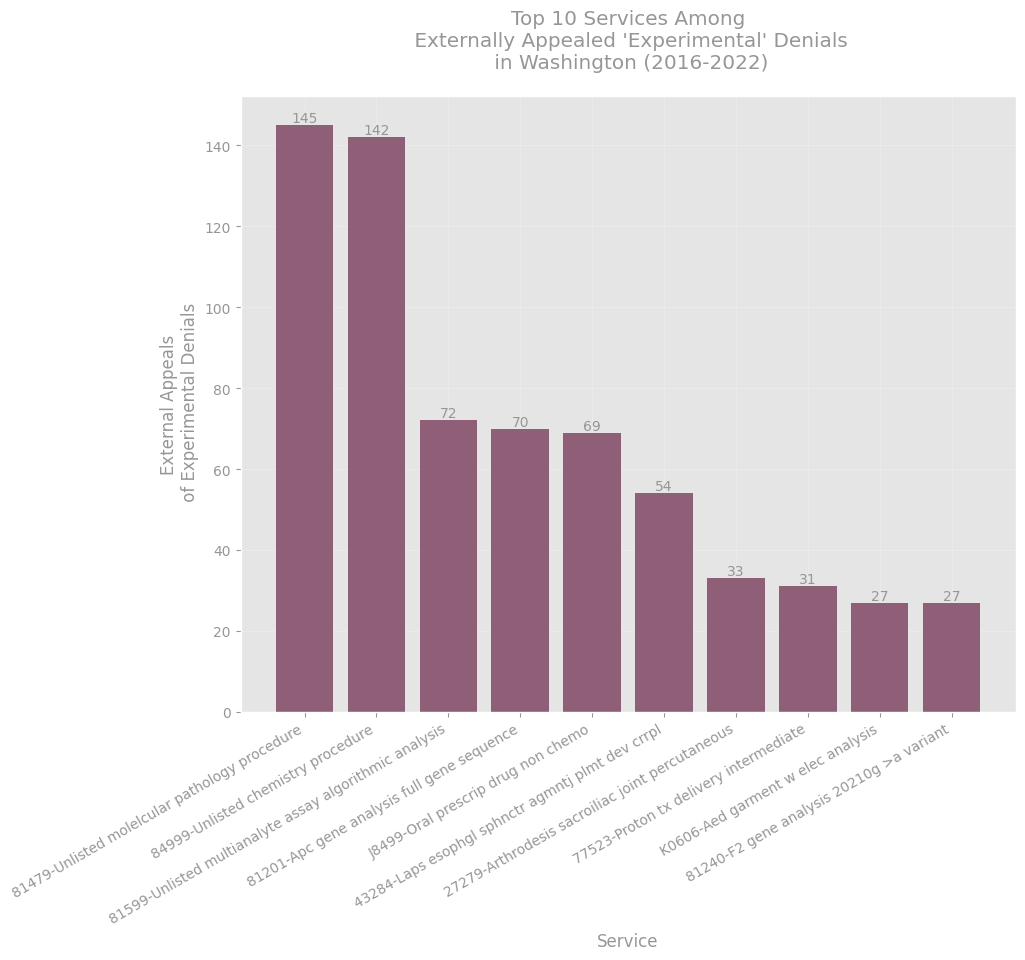

In [ ]:
# Service breakdowns among Experimental Denials
n = 10
title = f"Top {n} Services Among\n Externally Appealed 'Experimental' Denials\n in Washington (2016-2022)"
val_axis_label = "External Appeals\n of Experimental Denials"
cat_axis_label = "Service"
treat_val_counts = experimental["Treatment"].value_counts()[:n]
bar_names, bar_vals = [
    x.strip("[").strip("]").split("/")[0] for x in list(treat_val_counts.index)
], treat_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "top_experimental_appeal_services.png"),
    bar_label=True,
    figsize=(10, 8),
)

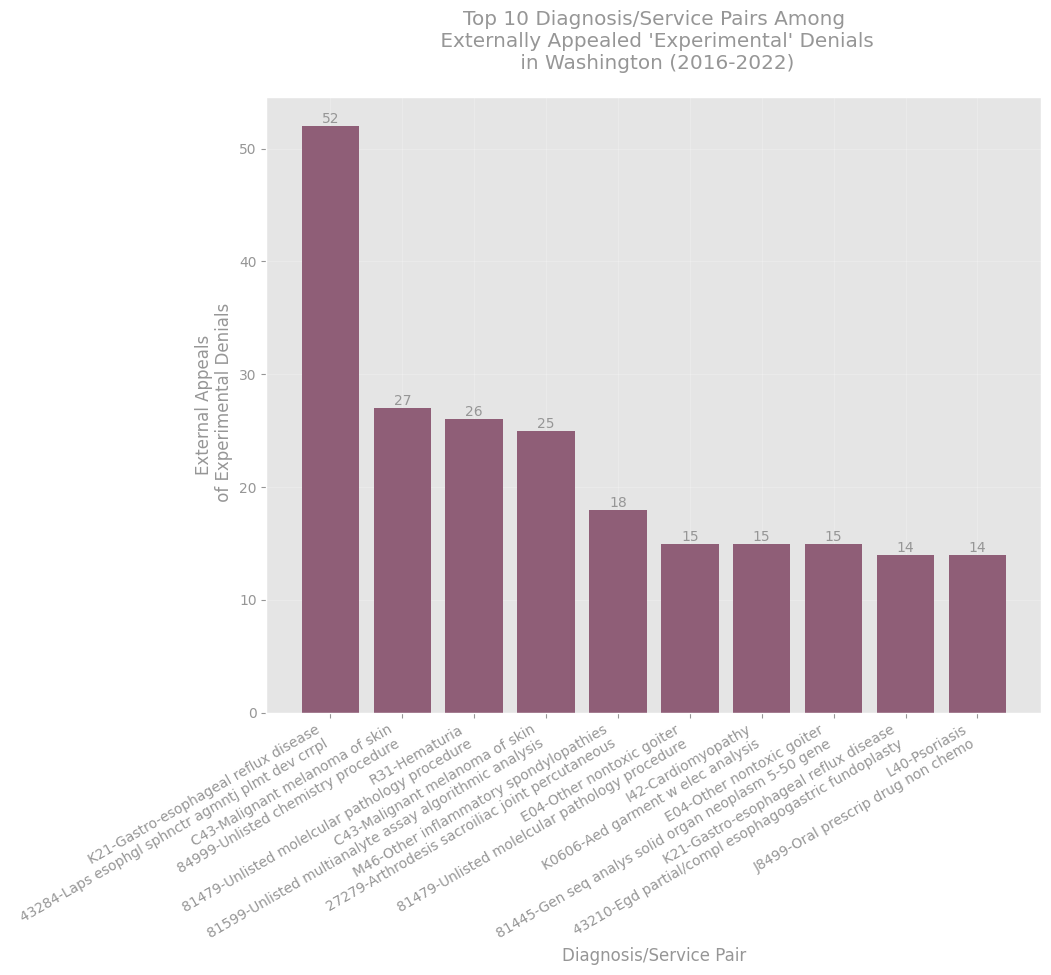

In [ ]:
# Diagnosis/Service Pair breakdowns among Experimental Denials
n = 10
title = f"Top {n} Diagnosis/Service Pairs Among\n Externally Appealed 'Experimental' Denials\n in Washington (2016-2022)"
val_axis_label = "External Appeals\n of Experimental Denials"
cat_axis_label = "Diagnosis/Service Pair"
diag_treat_pairs = (
    experimental.groupby(["Diagnosis", "Treatment"], as_index=False)
    .size()
    .sort_values(by="size", ascending=False)[:n]
)
bar_names, bar_vals = [
    x[0] + "\n" + x[1]
    for x in zip(
        diag_treat_pairs["Diagnosis"].values, diag_treat_pairs["Treatment"].values
    )
], diag_treat_pairs["size"].values
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(
        OUTPUT_IMAGE_DIR, "top_experimental_appeal_diag_services.png"
    ),
    bar_label=True,
    figsize=(10, 8),
)

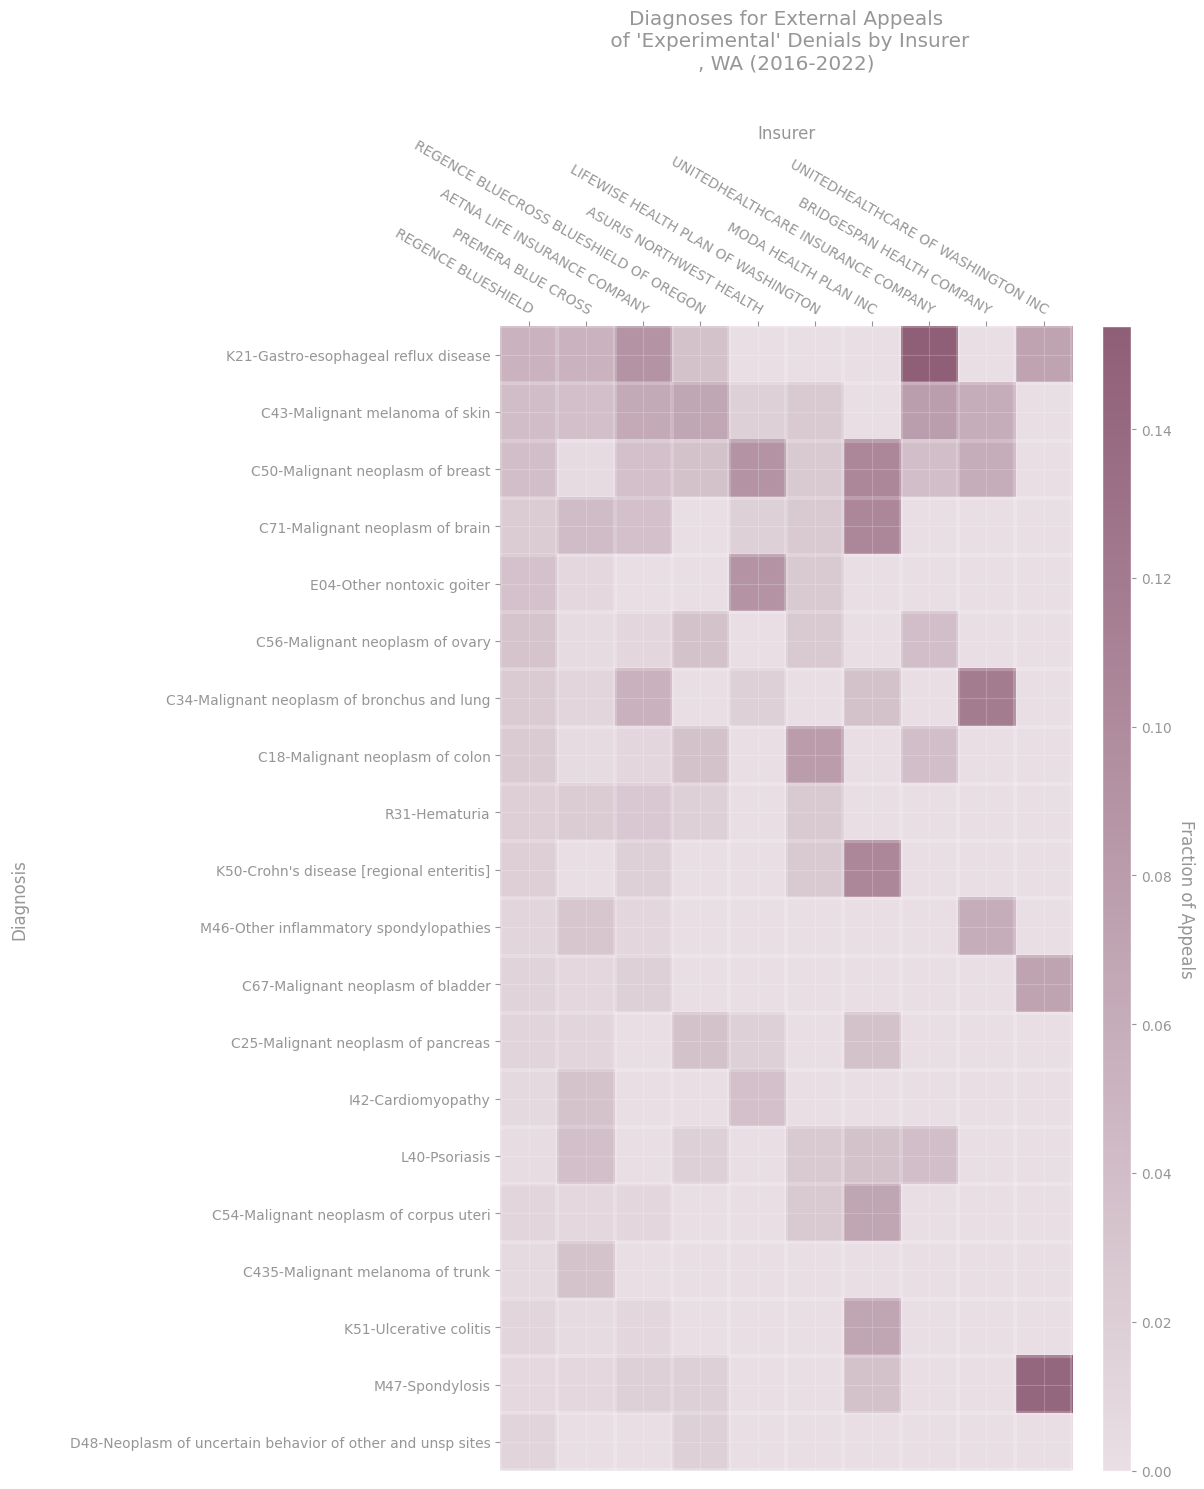

In [ ]:
heatmap_from_df_cols(
    experimental,
    col1="Diagnosis",
    col2="CompanyName",
    top_k1=20,
    top_k2=10,
    heat_val_name="Fraction of Appeals",
    normalize=True,
    title="Diagnoses for External Appeals\n of 'Experimental' Denials by Insurer,\n WA (2016-2022)",
    x_label="Insurer",
    y_label="Diagnosis",
    figsize=(12, 15),
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "experimental_diagnosis_by_insurer.png"),
)

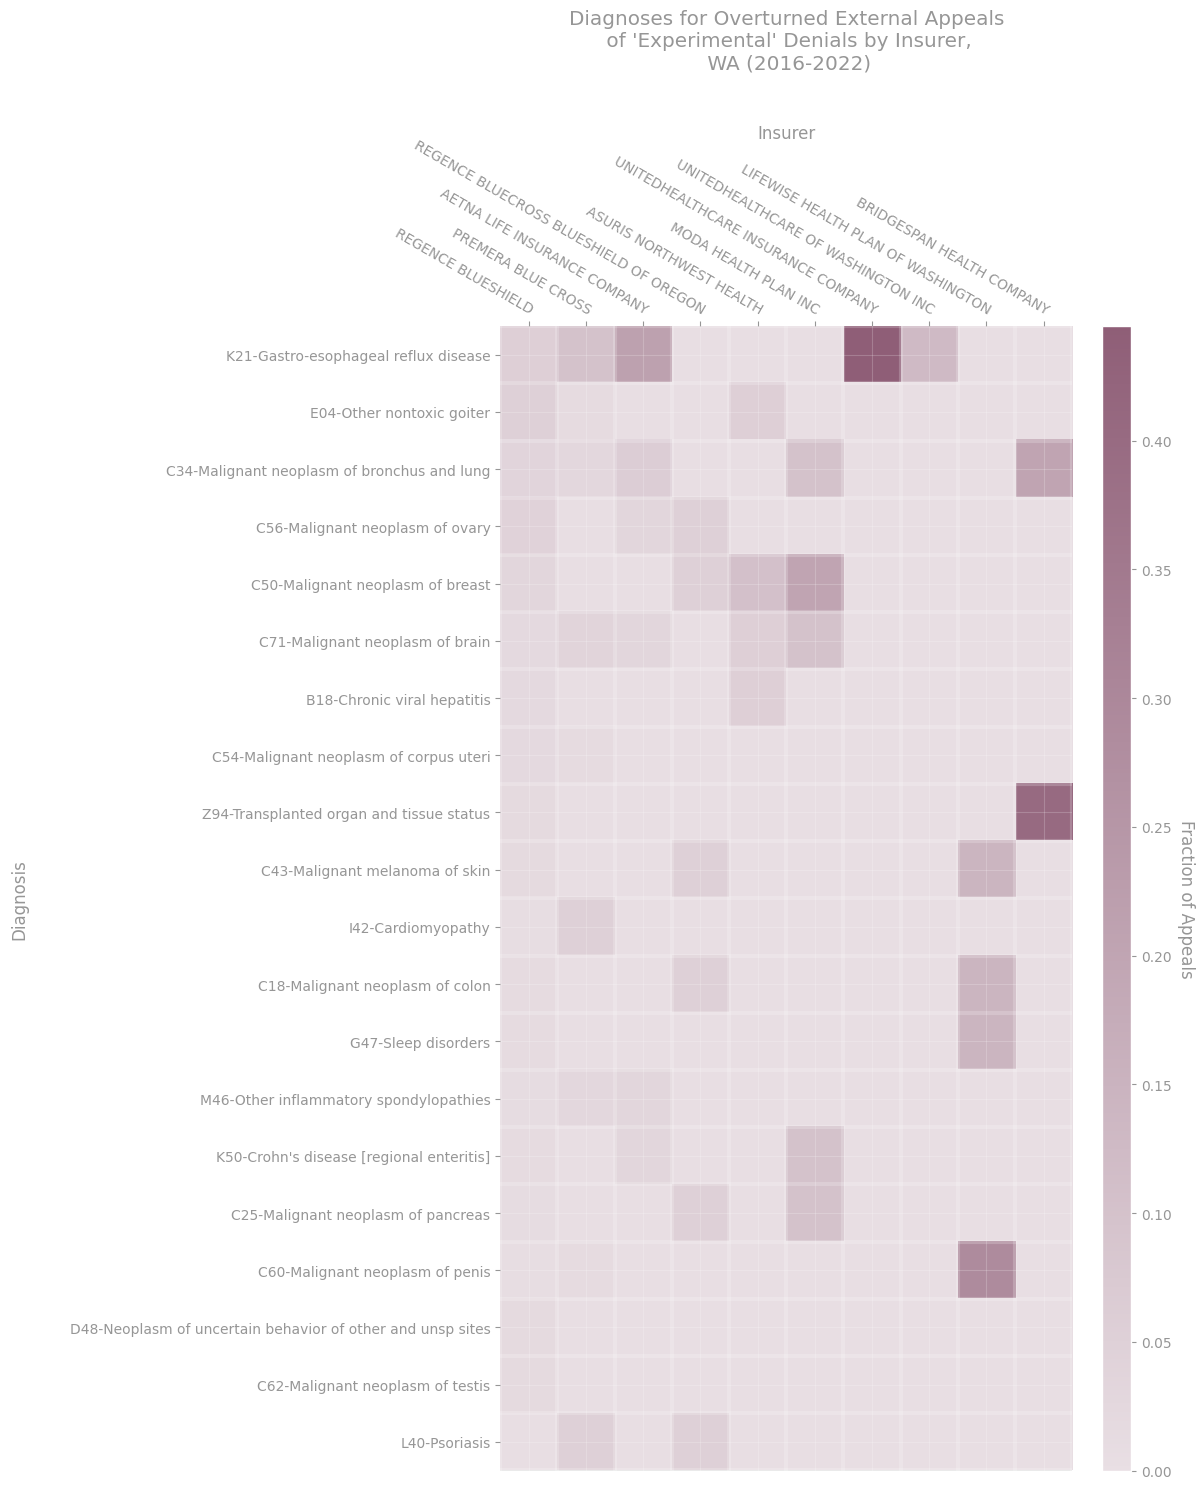

In [ ]:
heatmap_from_df_cols(
    overturned_experimental,
    col1="Diagnosis",
    col2="CompanyName",
    top_k1=20,
    top_k2=10,
    heat_val_name="Fraction of Appeals",
    normalize=True,
    title="Diagnoses for Overturned External Appeals\n of 'Experimental' Denials by Insurer,\n WA (2016-2022)",
    x_label="Insurer",
    y_label="Diagnosis",
    figsize=(12, 15),
    save_path=os.path.join(
        OUTPUT_IMAGE_DIR, "overturned_experimental_diagnosis_by_insurer.png"
    ),
)

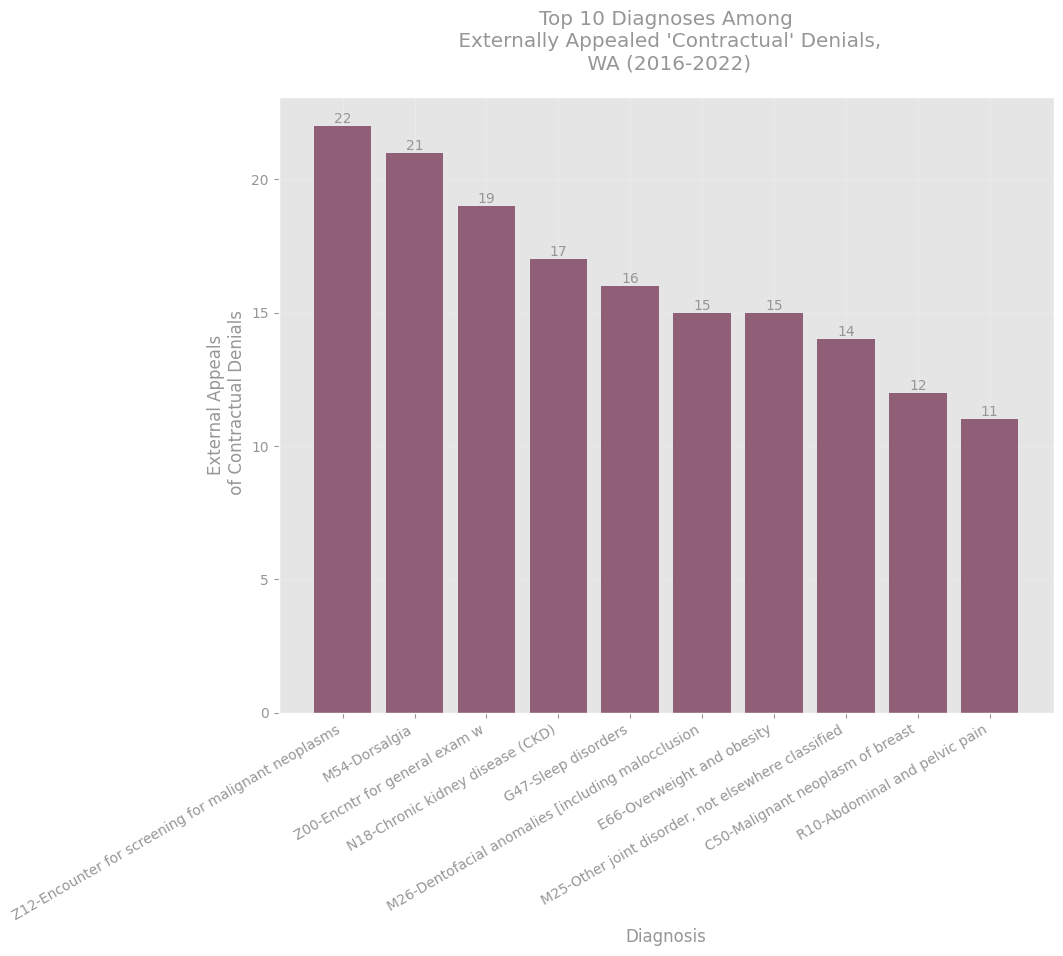

In [ ]:
# Diagnosis breakdowns among Contractual Denials
n = 10
title = f"Top {n} Diagnoses Among\n Externally Appealed 'Contractual' Denials,\n WA (2016-2022)"
val_axis_label = "External Appeals\n of Contractual Denials"
cat_axis_label = "Diagnosis"
diagnosis_val_counts = contractual["Diagnosis"].value_counts()[:n]
bar_names, bar_vals = [
    x.strip("[").strip("]").split("/")[0] for x in list(diagnosis_val_counts.index)
], diagnosis_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "top_contractual_appeal_diagnoses.png"),
    bar_label=True,
    figsize=(10, 8),
)

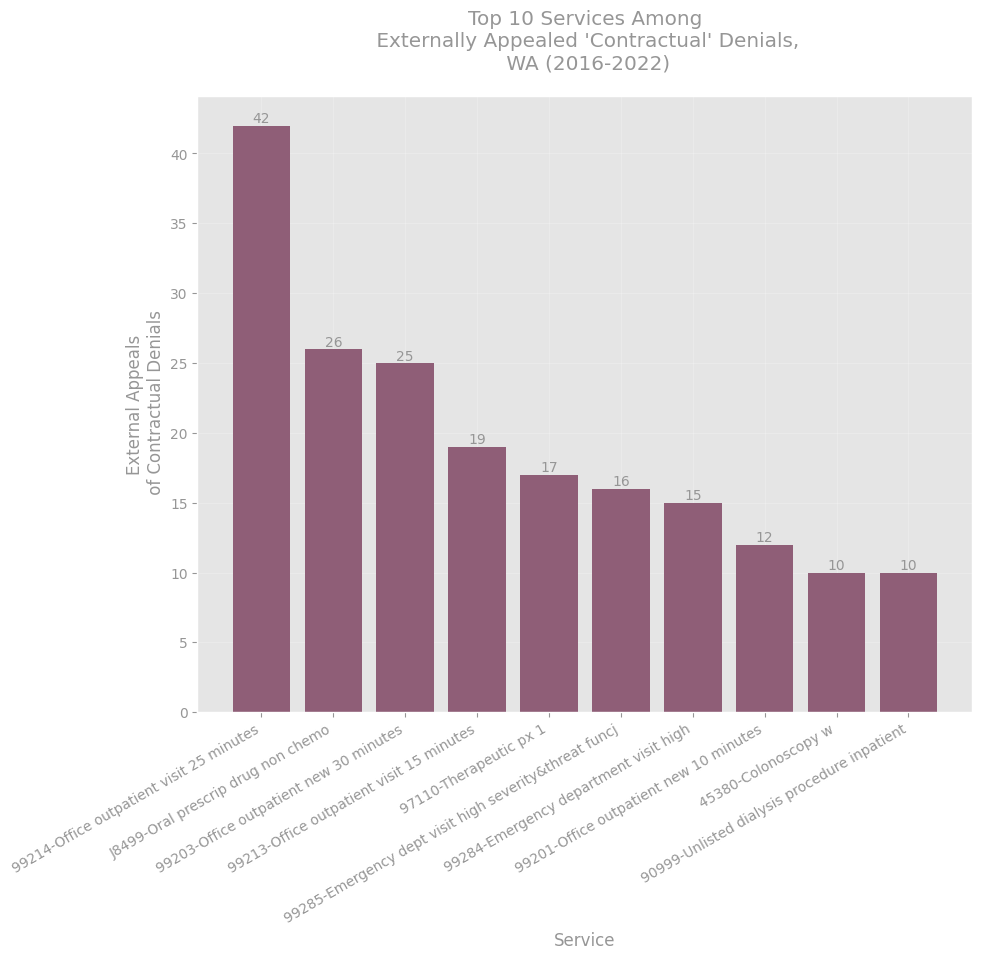

In [ ]:
# Service breakdowns among Contractual Denials
n = 10
title = f"Top {n} Services Among\n Externally Appealed 'Contractual' Denials,\n WA (2016-2022)"
val_axis_label = "External Appeals\n of Contractual Denials"
cat_axis_label = "Service"
diagnosis_val_counts = contractual["Treatment"].value_counts()[:n]
bar_names, bar_vals = [
    x.strip("[").strip("]").split("/")[0] for x in list(diagnosis_val_counts.index)
], diagnosis_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "top_contractual_appeal_services.png"),
    bar_label=True,
    figsize=(10, 8),
)

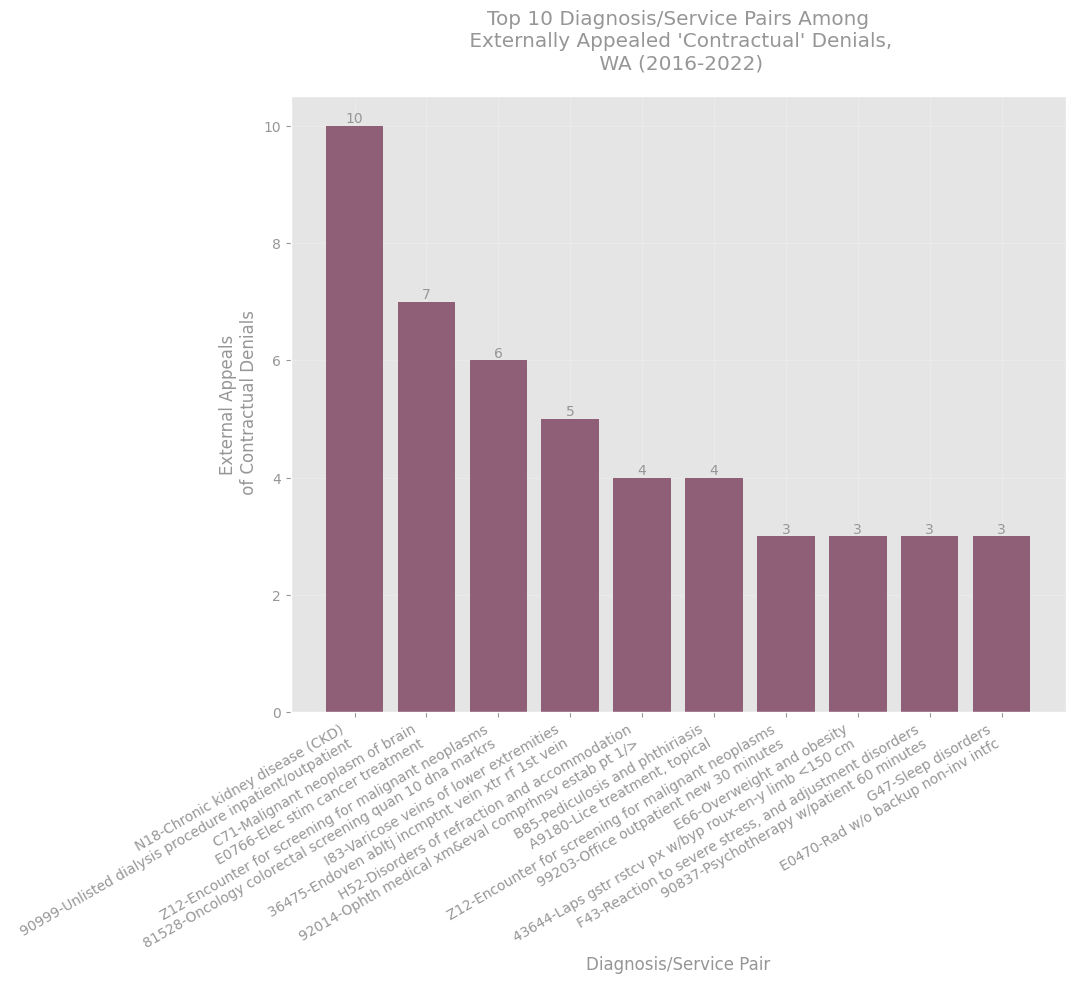

In [ ]:
# Service breakdowns among Contractual Denials
n = 10
title = f"Top {n} Diagnosis/Service Pairs Among\n Externally Appealed 'Contractual' Denials,\n WA (2016-2022)"
val_axis_label = "External Appeals\n of Contractual Denials"
cat_axis_label = "Diagnosis/Service Pair"
diag_treat_pairs = (
    contractual.groupby(["Diagnosis", "Treatment"], as_index=False)
    .size()
    .sort_values(by="size", ascending=False)[:n]
)
bar_names, bar_vals = [
    x[0] + "\n" + x[1]
    for x in zip(
        diag_treat_pairs["Diagnosis"].values, diag_treat_pairs["Treatment"].values
    )
], diag_treat_pairs["size"].values
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(
        OUTPUT_IMAGE_DIR, "top_contractual_appeal_diag_services.png"
    ),
    bar_label=True,
    figsize=(10, 8),
)

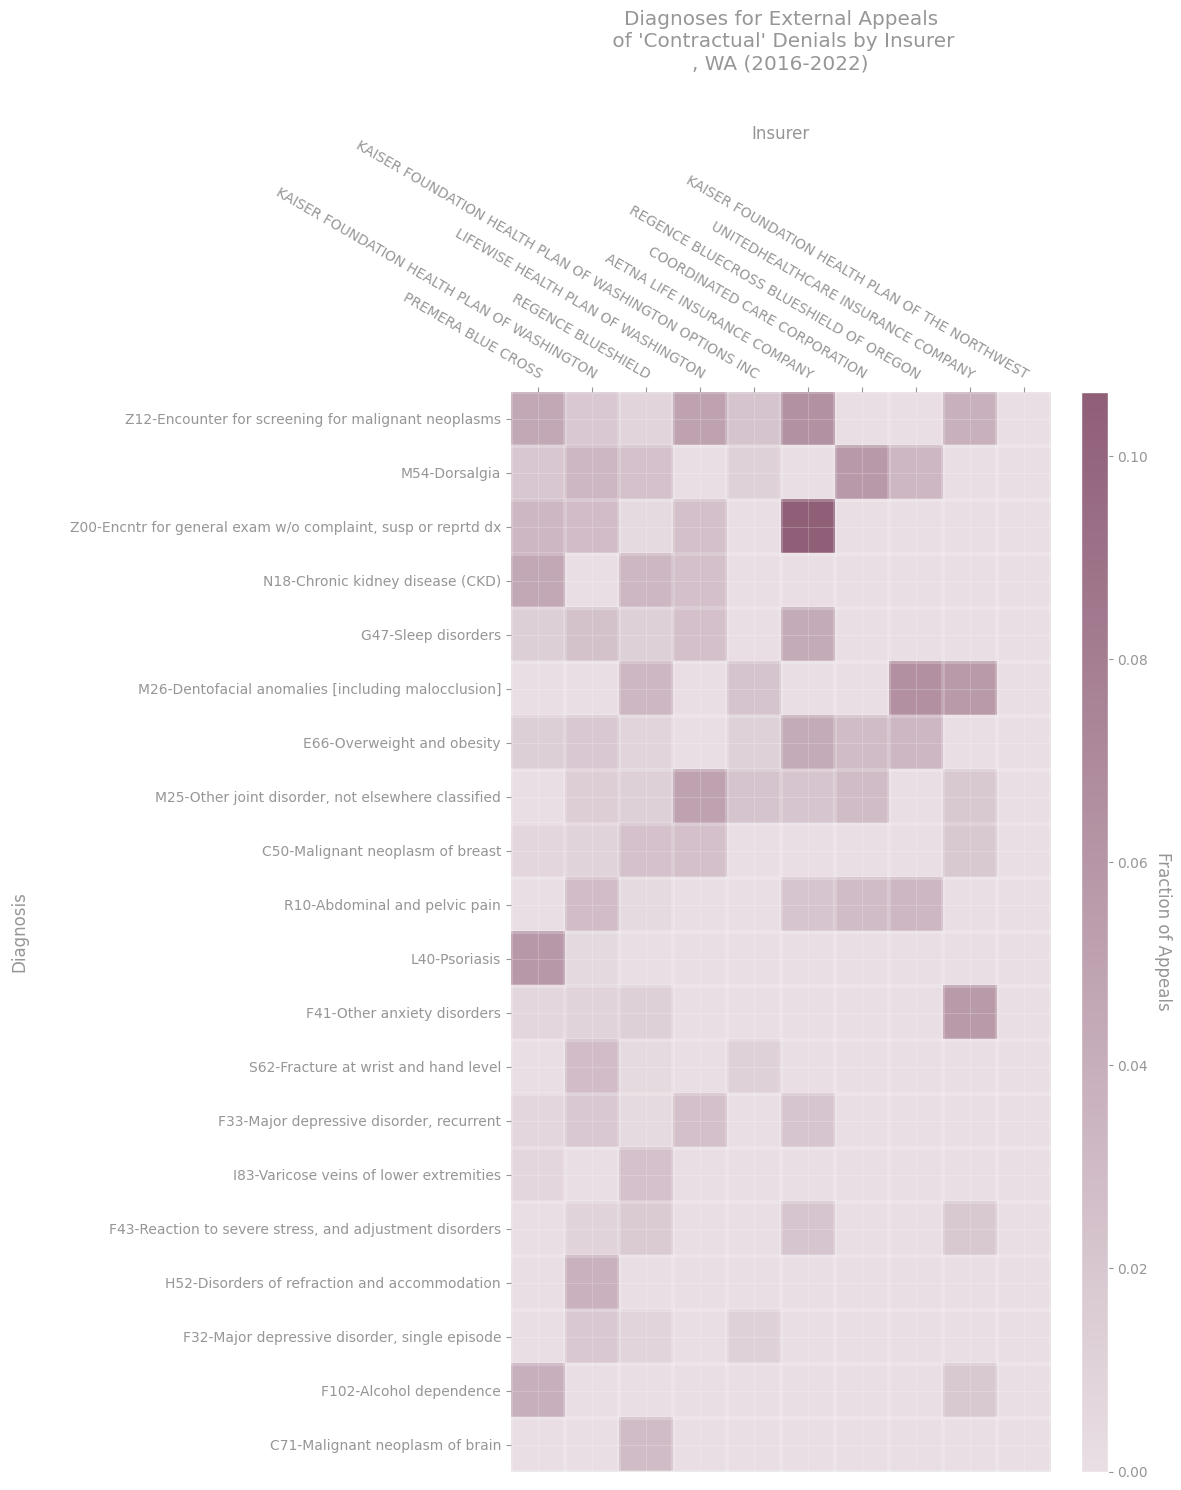

In [ ]:
heatmap_from_df_cols(
    contractual,
    col1="Diagnosis",
    col2="CompanyName",
    top_k1=20,
    top_k2=10,
    heat_val_name="Fraction of Appeals",
    normalize=True,
    title="Diagnoses for External Appeals\n of 'Contractual' Denials by Insurer\n, WA (2016-2022)",
    x_label="Insurer",
    y_label="Diagnosis",
    figsize=(12, 15),
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "contractual_diagnosis_by_insurer.png"),
)

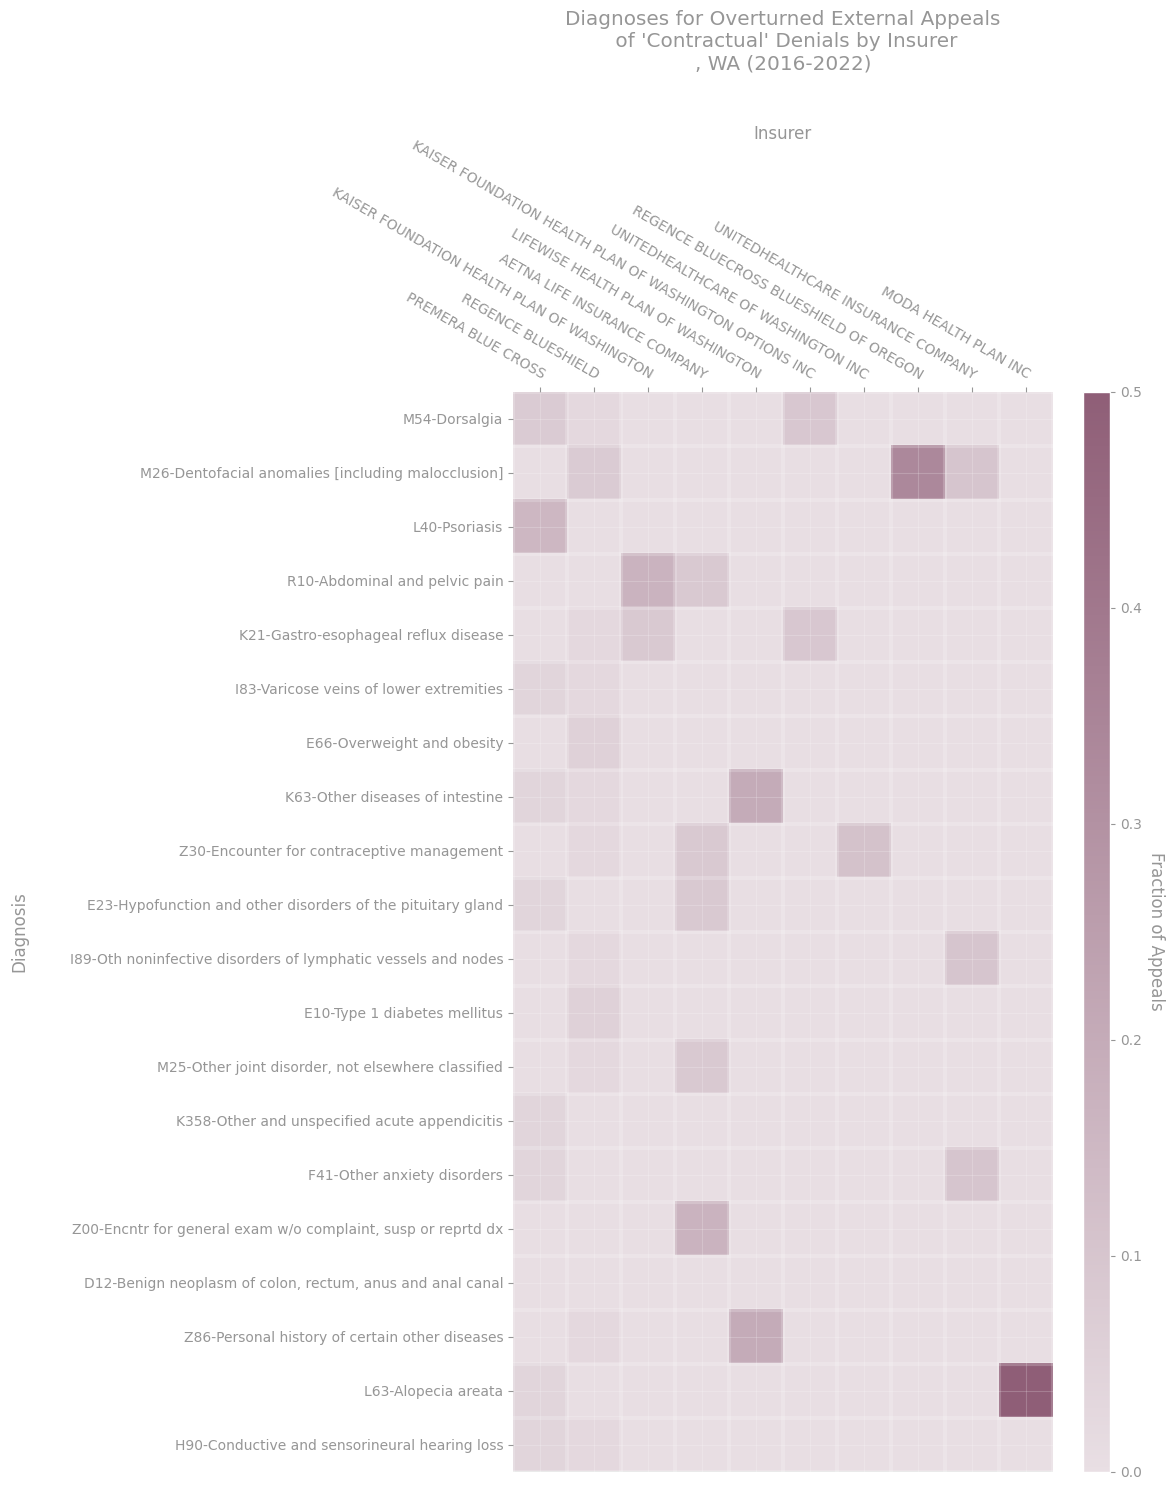

In [ ]:
heatmap_from_df_cols(
    overturned_contractual,
    col1="Diagnosis",
    col2="CompanyName",
    top_k1=20,
    top_k2=10,
    heat_val_name="Fraction of Appeals",
    normalize=True,
    title="Diagnoses for Overturned External Appeals\n of 'Contractual' Denials by Insurer\n, WA (2016-2022)",
    x_label="Insurer",
    y_label="Diagnosis",
    figsize=(12, 15),
    save_path=os.path.join(
        OUTPUT_IMAGE_DIR, "overturned_contractual_diagnosis_by_insurer.png"
    ),
)

### Breakdown by age

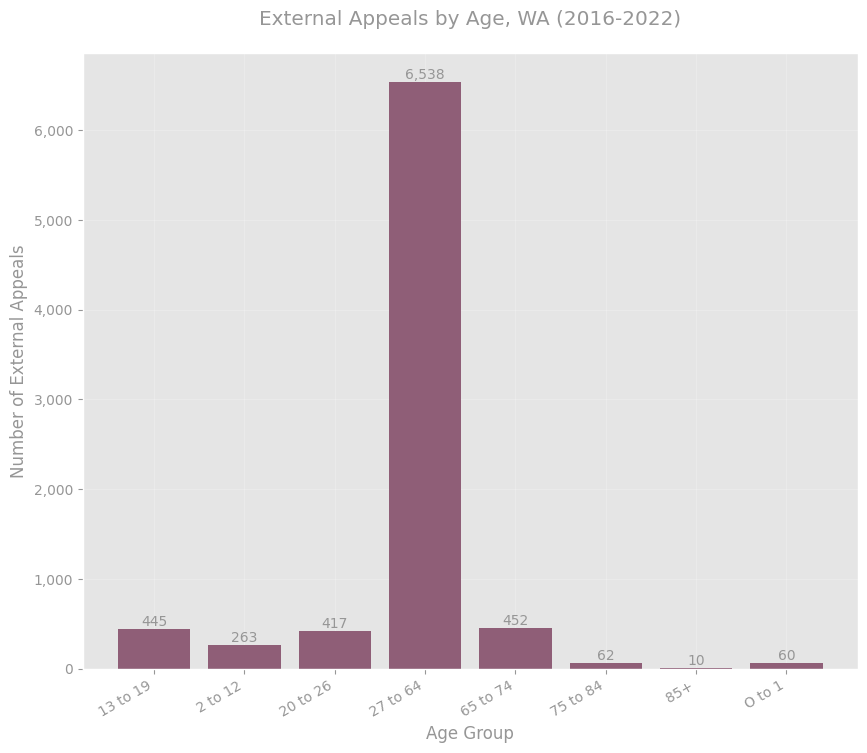

In [ ]:
appeals_by_age = df["Age Range"].value_counts()
bar_names, bar_vals = list(appeals_by_age.index), appeals_by_age.values
sort_order = np.argsort(bar_names)
bar_names = [bar_names[x] for x in sort_order]
bar_vals = [bar_vals[x] for x in sort_order]
title = "External Appeals by Age, WA (2016-2022)"
val_axis_label = "Number of External Appeals"
cat_axis_label = "Age Group"
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeal_counts_by_age.png"),
    bar_label=True,
    figsize=(10, 8),
)

### Breakdown by Gender

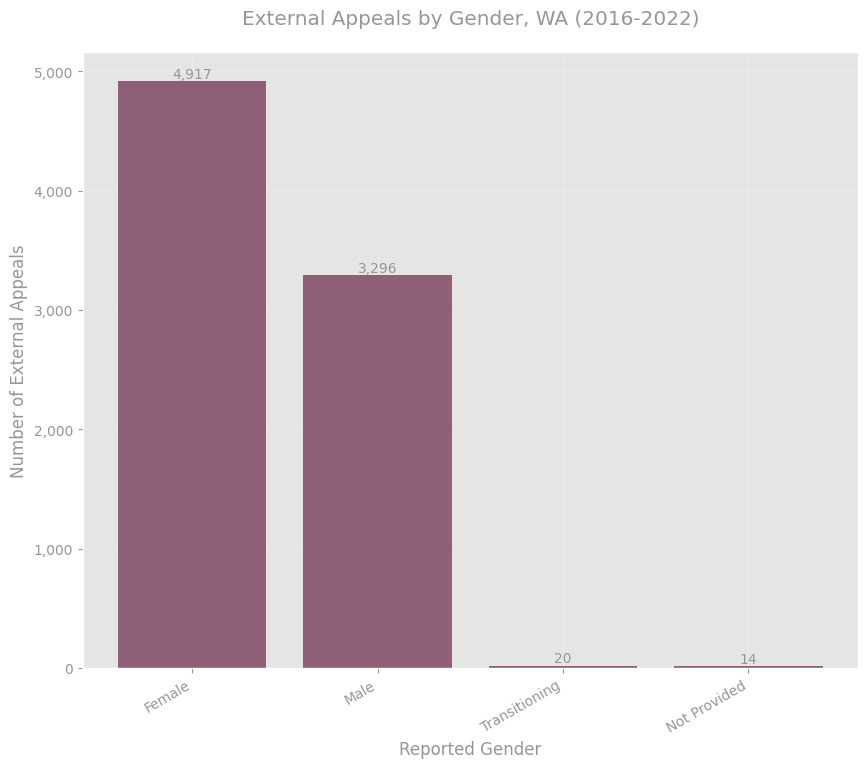

In [ ]:
appeals_by_age = df["Gender"].value_counts()
bar_names, bar_vals = list(appeals_by_age.index), appeals_by_age.values
title = "External Appeals by Gender, WA (2016-2022)"
val_axis_label = "Number of External Appeals"
cat_axis_label = "Reported Gender"
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeal_counts_by_gender.png"),
    bar_label=True,
    figsize=(10, 8),
)